In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as ad
import scanpy.external as sce
import decoupler as dc
# import scrublet as scr
# import muon as mu
#from vpolo.alevin import parser # to parse alevin output
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import statsmodels.stats.multitest as multi
from adjustText import adjust_text
import re

seed = 0
np.random.seed(seed)
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis', transparent=False, frameon=False)  # low dpi (dots per inch) yields small inline figures

import matplotlib as mpl
# 2 lines below solved the facecolor problem.
# mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = (1,1,1,1)
sc.settings.autosave = True
sc.logging.print_header()

version = '250407_BLD_downstream'
# input_table = '../data/231009_PBMC_HH514.csv'

results_file = '../scanpy/{}/res.h5ad'.format(version)
results_file_mu = '../scanpy/{}/res.h5mu'.format(version)
results_file_cellxgene = '../scanpy/{}/res.cxg.h5ad'.format(version)

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)

sc.settings.figdir = '../scanpy/{}/graph'.format(version)
sc.settings.cachedir = '../scanpy/{}/cache'.format(version)
# %config InlineBackend.figure_format = 'retina'

import os
os.makedirs('../scanpy/{}'.format(version), exist_ok=True)
os.makedirs(sc.settings.figdir, exist_ok=True)

2025-05-02 16:27:38.428501: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-02 16:27:38.444726: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-02 16:27:38.461731: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-02 16:27:38.466059: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-02 16:27:38.480441: I tensorflow/core/platform/cpu_feature_guar

scanpy==1.10.2 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.13.0 pandas==2.2.3 scikit-learn==1.5.1 statsmodels==0.14.2 igraph==0.11.6 pynndescent==0.5.13


In [3]:
adata = sc.read('/home/yy693/pi_hafler/ASAP/scanpy/241021_BLD_integrate/241021_BLD_integrate.h5ad')

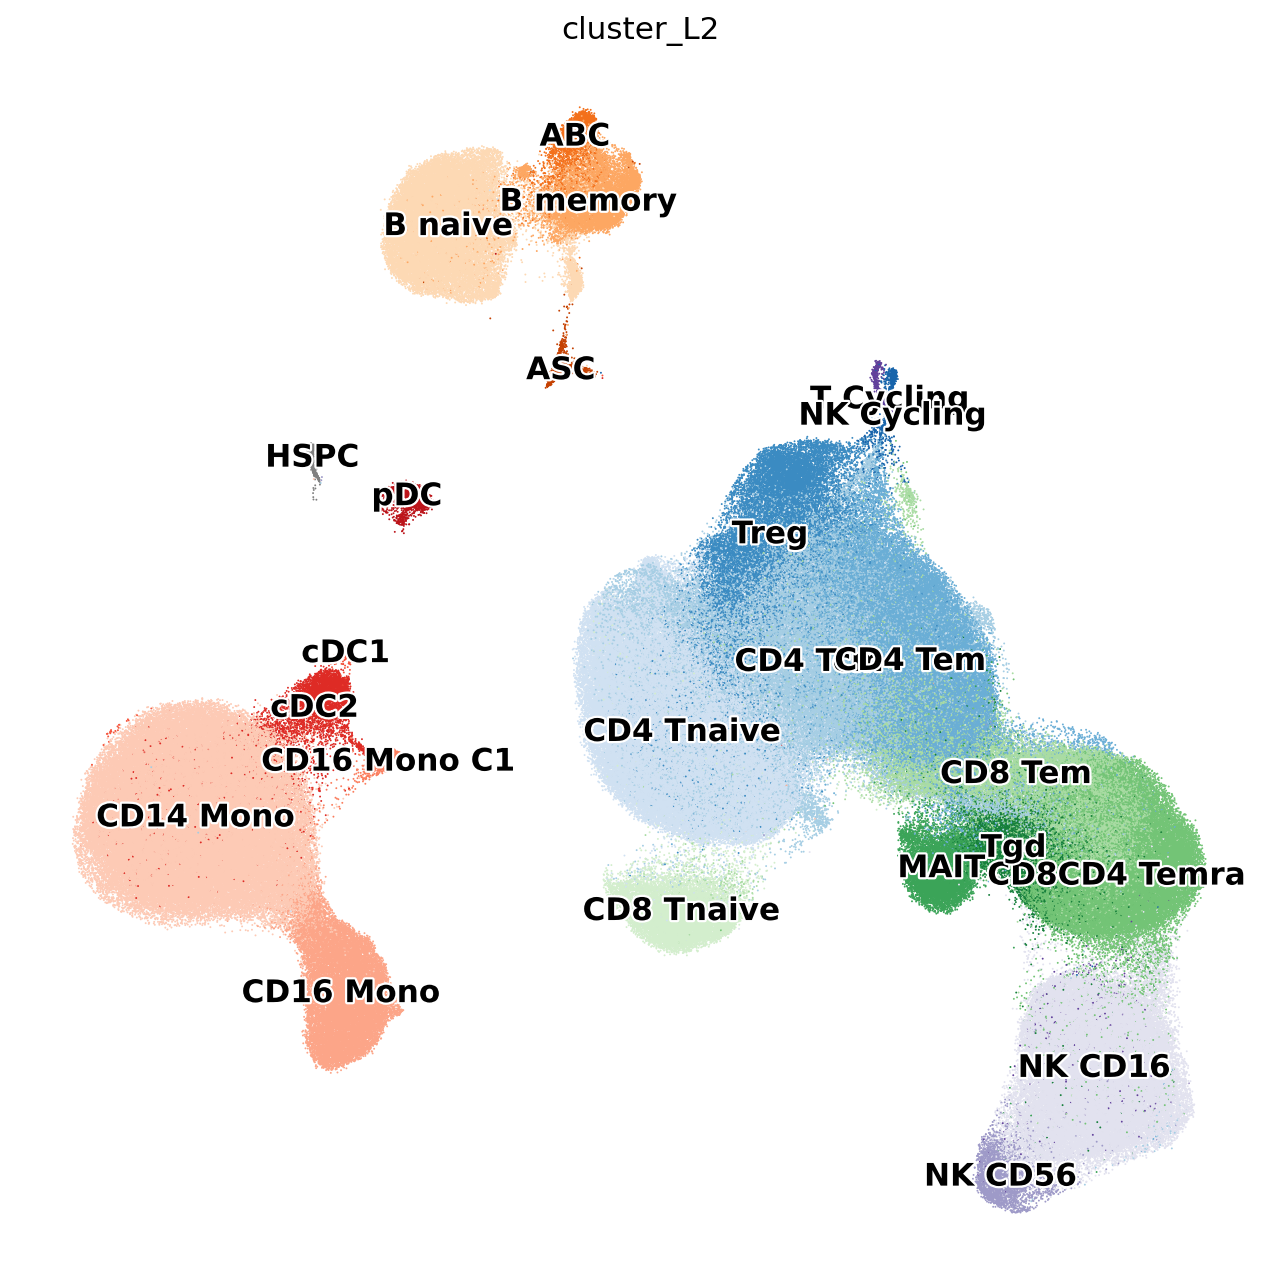

In [4]:
with plt.rc_context({"figure.figsize": (10, 10)}):
    sc.pl.embedding(
        adata,
        basis="umap_filtered",
        s=3,
        color="cluster_L2",
        legend_loc="on data",
        legend_fontsize=14,
        legend_fontoutline=2,
        frameon=False,
        # add_outline=True,
        # outline_width=(0.1, 5),
        # palette=cluster_palette,
        save='filter_reembed_cluster_L2_color_gradation.pdf'
    )

In [5]:
df_rbd = pd.read_excel('../data/CSF_cellfreq_clin_RBD_v2.xlsx')
df_rbd = df_rbd[['Subject', 'PD_Probability', 'Biomarkers_Positive']]

adata.obs = pd.merge(adata.obs.reset_index(), df_rbd, left_on='DonorID', right_on='Subject', how='left').set_index('index')
adata.obs['PD_Probability'] = adata.obs['PD_Probability'].astype(str)
adata.obs['Biomarkers_Positive'] = adata.obs['Biomarkers_Positive'].astype(str)

adata.obs['PD_Probability'] = (adata.obs['EnrollmentCategory'].astype(str) + '-' + adata.obs['PD_Probability']).str.replace('-nan', '')
adata.obs['Biomarkers_Positive'] = (adata.obs['EnrollmentCategory'].astype(str) + '-' + adata.obs['Biomarkers_Positive']).str.replace('-nan', '')

In [6]:
adata.obs[['DonorID', 'Age', 'Gender', 'EnrollmentCategory', 'PD_Probability', 'Biomarkers_Positive']].drop_duplicates().reset_index(drop=True).to_csv('../scanpy/{}/metadata.csv'.format(version), index=False)

In [8]:
adata.write(results_file)
adata_cxg = sc.AnnData(adata.raw.X)
adata_cxg.obs = adata.obs
adata_cxg.obsm = adata.obsm
adata_cxg.var.index = adata.raw.var.index
adata_cxg.uns['cluster_L2_colors'] = adata.uns['cluster_L2_colors']
adata_cxg.write(results_file_cellxgene)

In [26]:
adata.obs.to_csv(f'../scanpy/{version}/obs.csv')

In [27]:
msigdb = dc.get_resource('MSigDB')
msigdb


genesymbol                          collection  \
0             MAFF  chemical_and_genetic_perturbations   
1             MAFF  chemical_and_genetic_perturbations   
2             MAFF  chemical_and_genetic_perturbations   
3             MAFF                         immunesigdb   
4             MAFF  chemical_and_genetic_perturbations   
...            ...                                 ...   
3838543   PRAMEF22               go_biological_process   
3838544   PRAMEF22               go_biological_process   
3838545   PRAMEF22               go_biological_process   
3838546   PRAMEF22               go_biological_process   
3838547   PRAMEF22               go_biological_process   

                                                   geneset  
0                     BOYAULT_LIVER_CANCER_SUBCLASS_G56_DN  
1                                       ELVIDGE_HYPOXIA_UP  
2                                 NUYTTEN_NIPP1_TARGETS_DN  
3                GSE17721_POLYIC_VS_GARDIQUIMOD_4H_BMDC_DN  
4                   SCHAEFFER_PROSTATE_DEVELOPMENT_12HR_UP  
...                                                    ...  
3838543  GOBP_POSITIVE_REGULATION_OF_CELL_POPULATION_PR...  
3838544                             GOBP_APOPTOTIC_PROCESS  
3838545                      GOBP_REGULATION_OF_CELL_DEATH  
3838546  GOBP_NEGATIVE_REGULATION_OF_DEVELOPMENTAL_PROCESS  
3838547             GOBP_NEGATIVE_REGULATION_OF_CELL_DEATH  

[3838548 rows x 3 columns]

In [28]:
# Filter by hallmark
msigdb = msigdb[msigdb['collection']=='hallmark']

# Remove duplicated entries
msigdb = msigdb[~msigdb.duplicated(['geneset', 'genesymbol'])]
msigdb

genesymbol collection                           geneset
233           MAFF   hallmark      HALLMARK_IL2_STAT5_SIGNALING
250           MAFF   hallmark              HALLMARK_COAGULATION
270           MAFF   hallmark                  HALLMARK_HYPOXIA
373           MAFF   hallmark  HALLMARK_TNFA_SIGNALING_VIA_NFKB
377           MAFF   hallmark               HALLMARK_COMPLEMENT
...            ...        ...                               ...
1449668     STXBP1   hallmark      HALLMARK_PANCREAS_BETA_CELLS
1450315       ELP4   hallmark      HALLMARK_PANCREAS_BETA_CELLS
1450526        GCG   hallmark      HALLMARK_PANCREAS_BETA_CELLS
1450731      PCSK2   hallmark      HALLMARK_PANCREAS_BETA_CELLS
1450916       PAX6   hallmark      HALLMARK_PANCREAS_BETA_CELLS

[7318 rows x 3 columns]

In [29]:
dc.run_ora(
    mat=adata,
    net=msigdb,
    source='geneset',
    target='genesymbol',
    verbose=True
)

Running ora on mat with 523521 samples and 26640 targets for 50 sources.


  0%|          | 0/523521 [00:00<?, ?it/s]

In [ ]:
acts = dc.get_acts(adata, obsm_key='ora_estimate')

# We need to remove inf and set them to the maximum value observed
acts_v = acts.X.ravel()
max_e = np.nanmax(acts_v[np.isfinite(acts_v)])
acts.X[~np.isfinite(acts.X)] = max_e

acts

AnnData object with n_obs × n_vars = 523521 × 50
    obs: 'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Year1stDLBSx', 'YearDLBDX', 'DLBAAO

In [ ]:
acts.var.index = acts.var.index.astype(str)
acts.write(f'../scanpy/{version}/ora_hallmark.h5ad')

In [ ]:
acts = sc.read(f'../scanpy/{version}/ora_hallmark.h5ad')

In [5]:
acts.var

Empty DataFrame
Columns: []
Index: [HALLMARK_ADIPOGENESIS, HALLMARK_ALLOGRAFT_REJECTION, HALLMARK_ANDROGEN_RESPONSE, HALLMARK_ANGIOGENESIS, HALLMARK_APICAL_JUNCTION, HALLMARK_APICAL_SURFACE, HALLMARK_APOPTOSIS, HALLMARK_BILE_ACID_METABOLISM, HALLMARK_CHOLESTEROL_HOMEOSTASIS, HALLMARK_COAGULATION, HALLMARK_COMPLEMENT, HALLMARK_DNA_REPAIR, HALLMARK_E2F_TARGETS, HALLMARK_EPITHELIAL_MESENCHYMAL_TRANSITION, HALLMARK_ESTROGEN_RESPONSE_EARLY, HALLMARK_ESTROGEN_RESPONSE_LATE, HALLMARK_FATTY_ACID_METABOLISM, HALLMARK_G2M_CHECKPOINT, HALLMARK_GLYCOLYSIS, HALLMARK_HEDGEHOG_SIGNALING, HALLMARK_HEME_METABOLISM, HALLMARK_HYPOXIA, HALLMARK_IL2_STAT5_SIGNALING, HALLMARK_IL6_JAK_STAT3_SIGNALING, HALLMARK_INFLAMMATORY_RESPONSE, HALLMARK_INTERFERON_ALPHA_RESPONSE, HALLMARK_INTERFERON_GAMMA_RESPONSE, HALLMARK_KRAS_SIGNALING_DN, HALLMARK_KRAS_SIGNALING_UP, HALLMARK_MITOTIC_SPINDLE, HALLMARK_MTORC1_SIGNALING, HALLMARK_MYC_TARGETS_V1, HALLMARK_MYC_TARGETS_V2, HALLMARK_MYOGENESIS, HALLMARK_NOTCH_SIGNALING, HALLMARK_OXIDATIVE_PHOSPHORYLATION, HALLMARK_P53_PATHWAY, HALLMARK_PANCREAS_BETA_CELLS, HALLMARK_PEROXISOME, HALLMARK_PI3K_AKT_MTOR_SIGNALING, HALLMARK_PROTEIN_SECRETION, HALLMARK_REACTIVE_OXYGEN_SPECIES_PATHWAY, HALLMARK_SPERMATOGENESIS, HALLMARK_TGF_BETA_SIGNALING, HALLMARK_TNFA_SIGNALING_VIA_NFKB, HALLMARK_UNFOLDED_PROTEIN_RESPONSE, HALLMARK_UV_RESPONSE_DN, HALLMARK_UV_RESPONSE_UP, HALLMARK_WNT_BETA_CATENIN_SIGNALING, HALLMARK_XENOBIOTIC_METABOLISM]

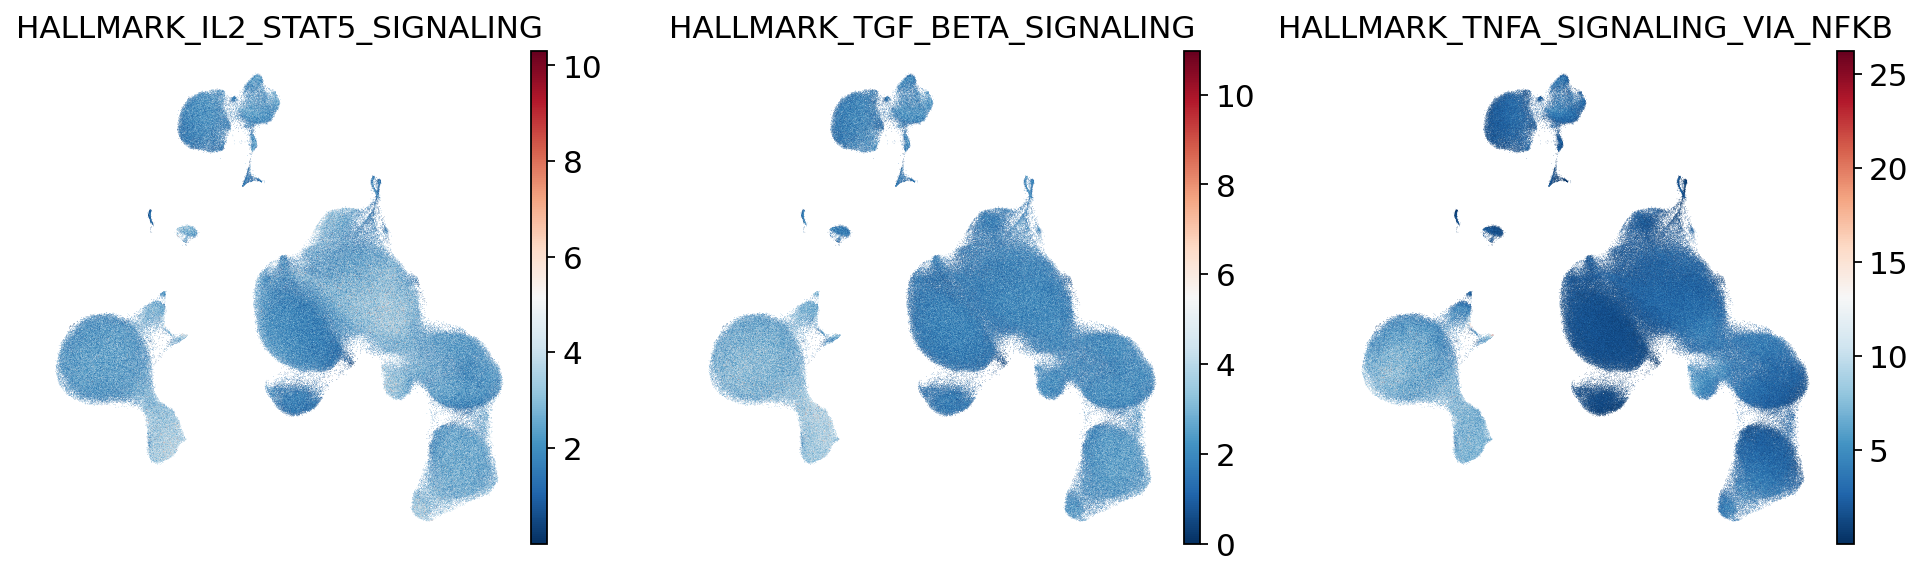

In [10]:
sc.pl.embedding(
        acts,
        basis="umap_filtered", 
        color=['HALLMARK_IL2_STAT5_SIGNALING',
        'HALLMARK_TGF_BETA_SIGNALING',
        'HALLMARK_TNFA_SIGNALING_VIA_NFKB',
        ], cmap='RdBu_r')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_cluster_L2']`


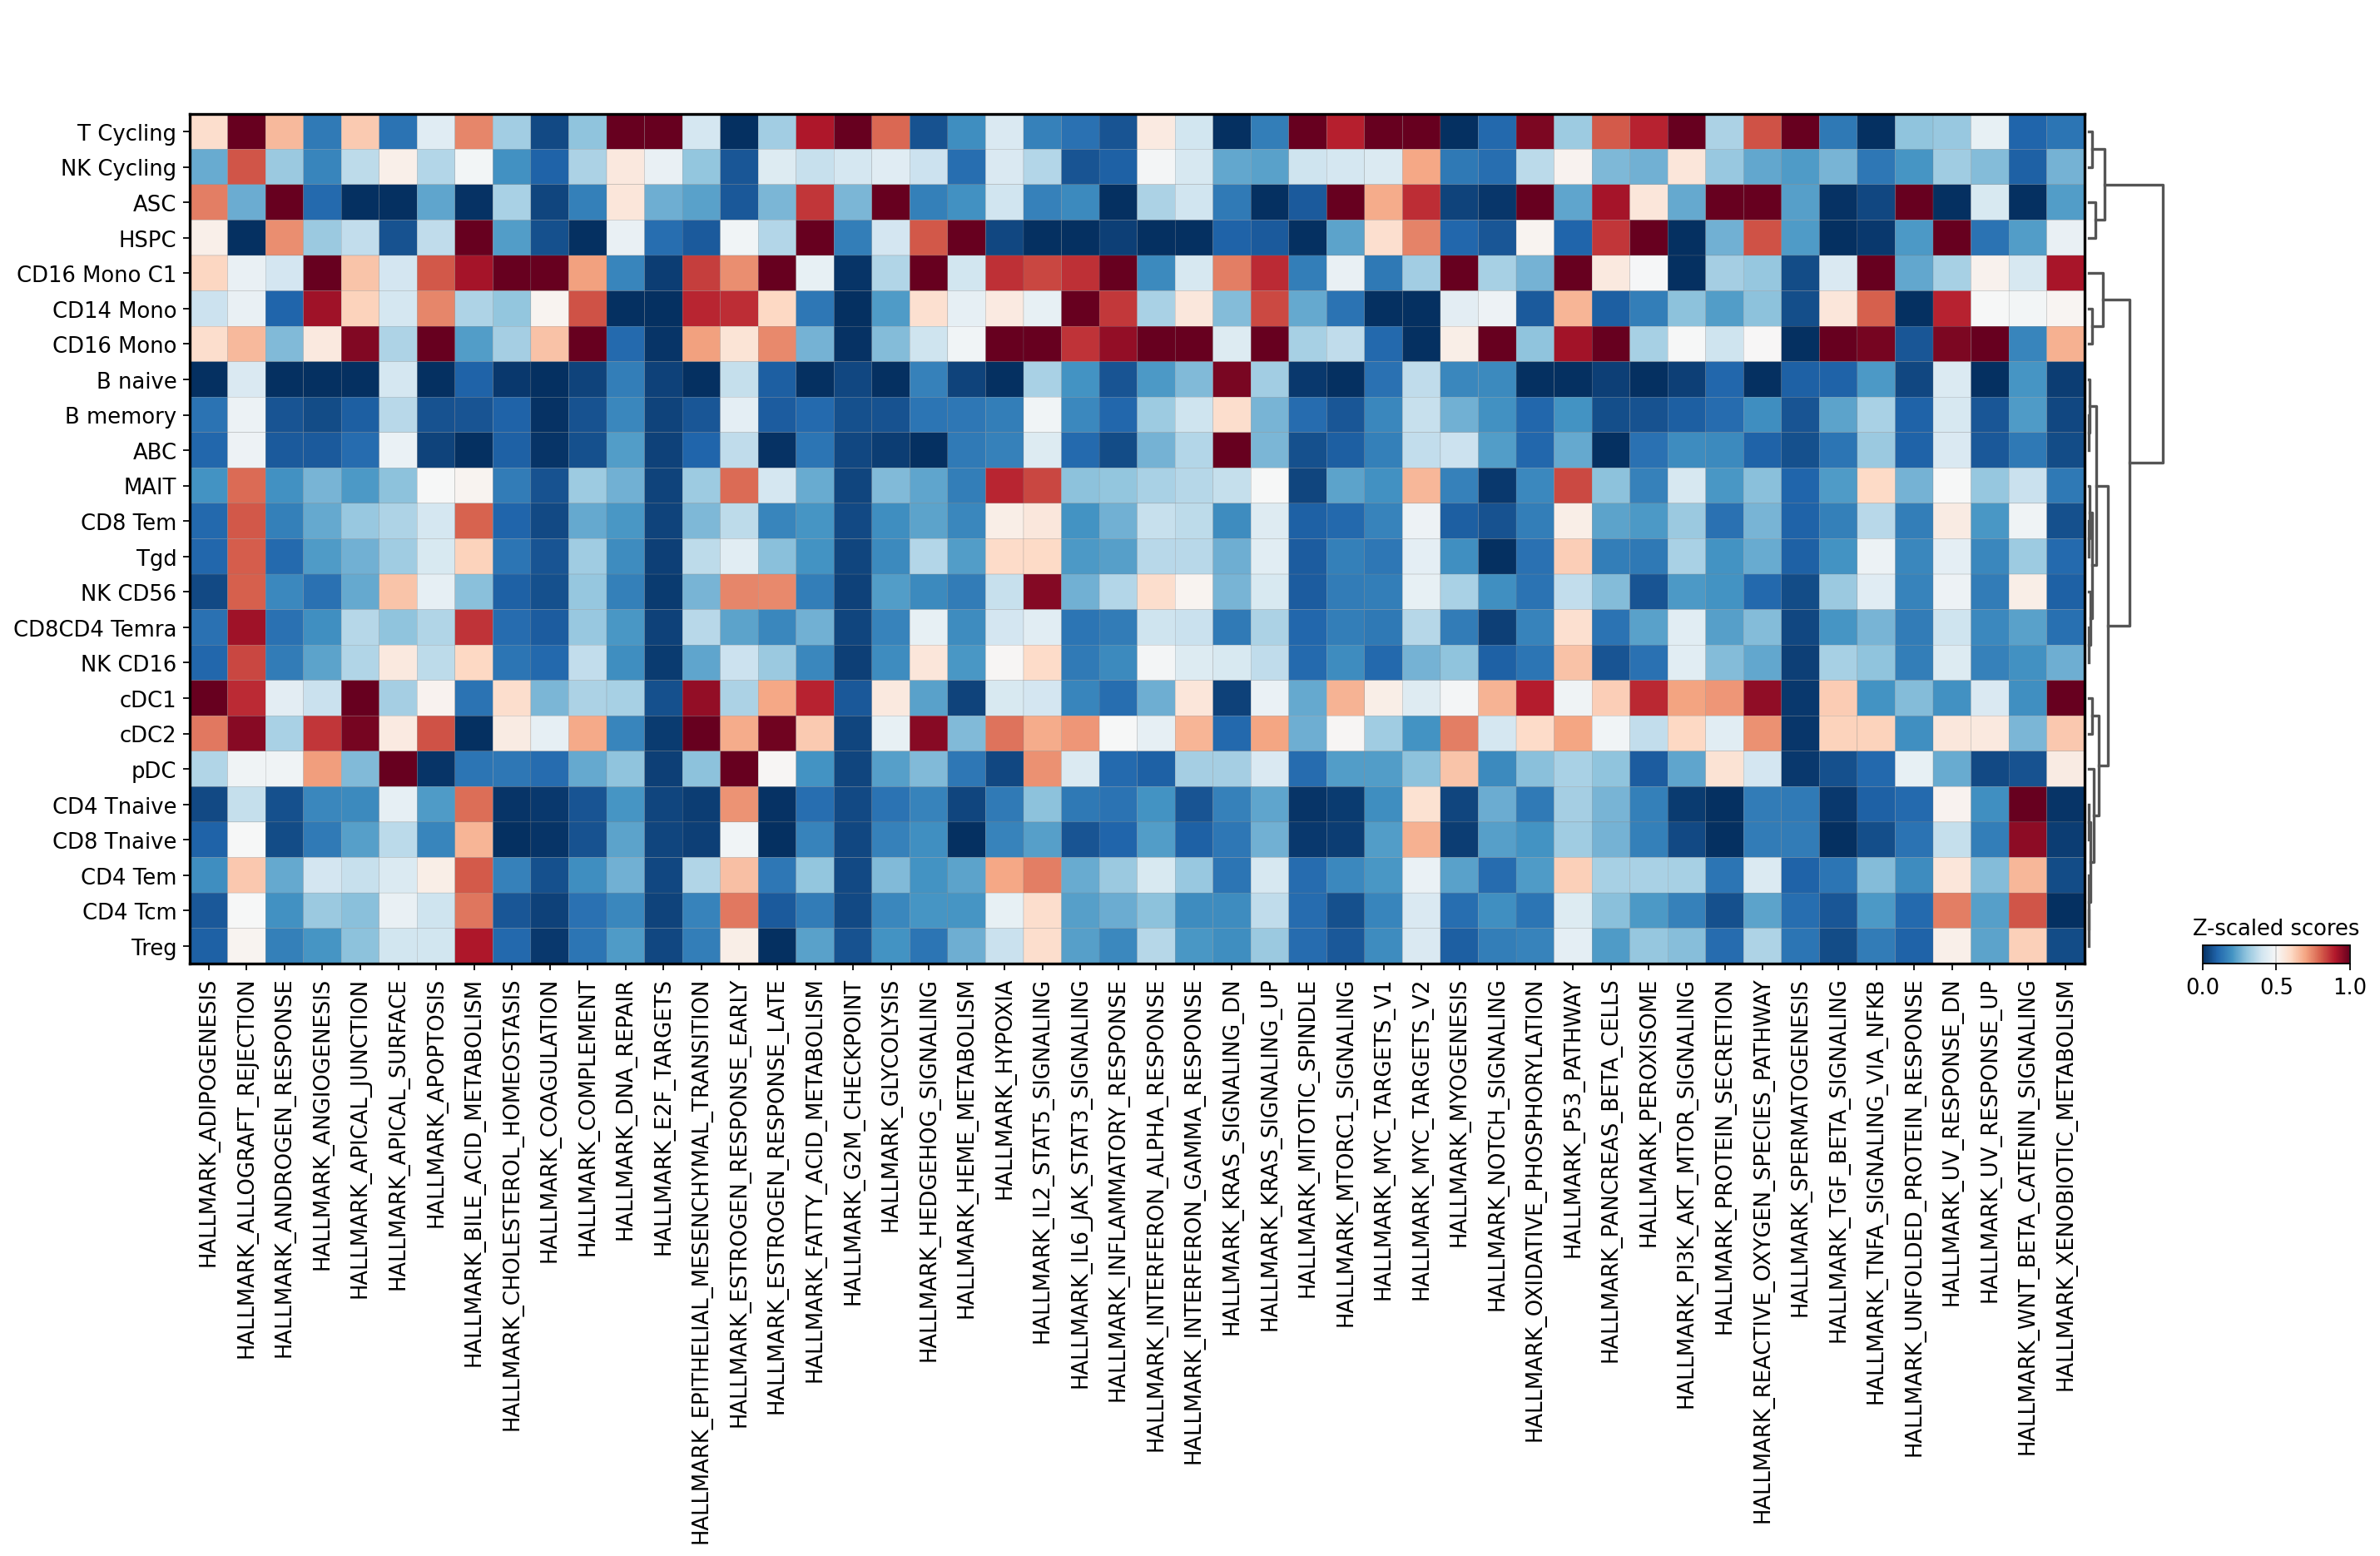

In [11]:
sc.pl.matrixplot(acts, var_names=acts.var_names, groupby='cluster_L2', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_EnrollmentCategory']`


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:193: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat


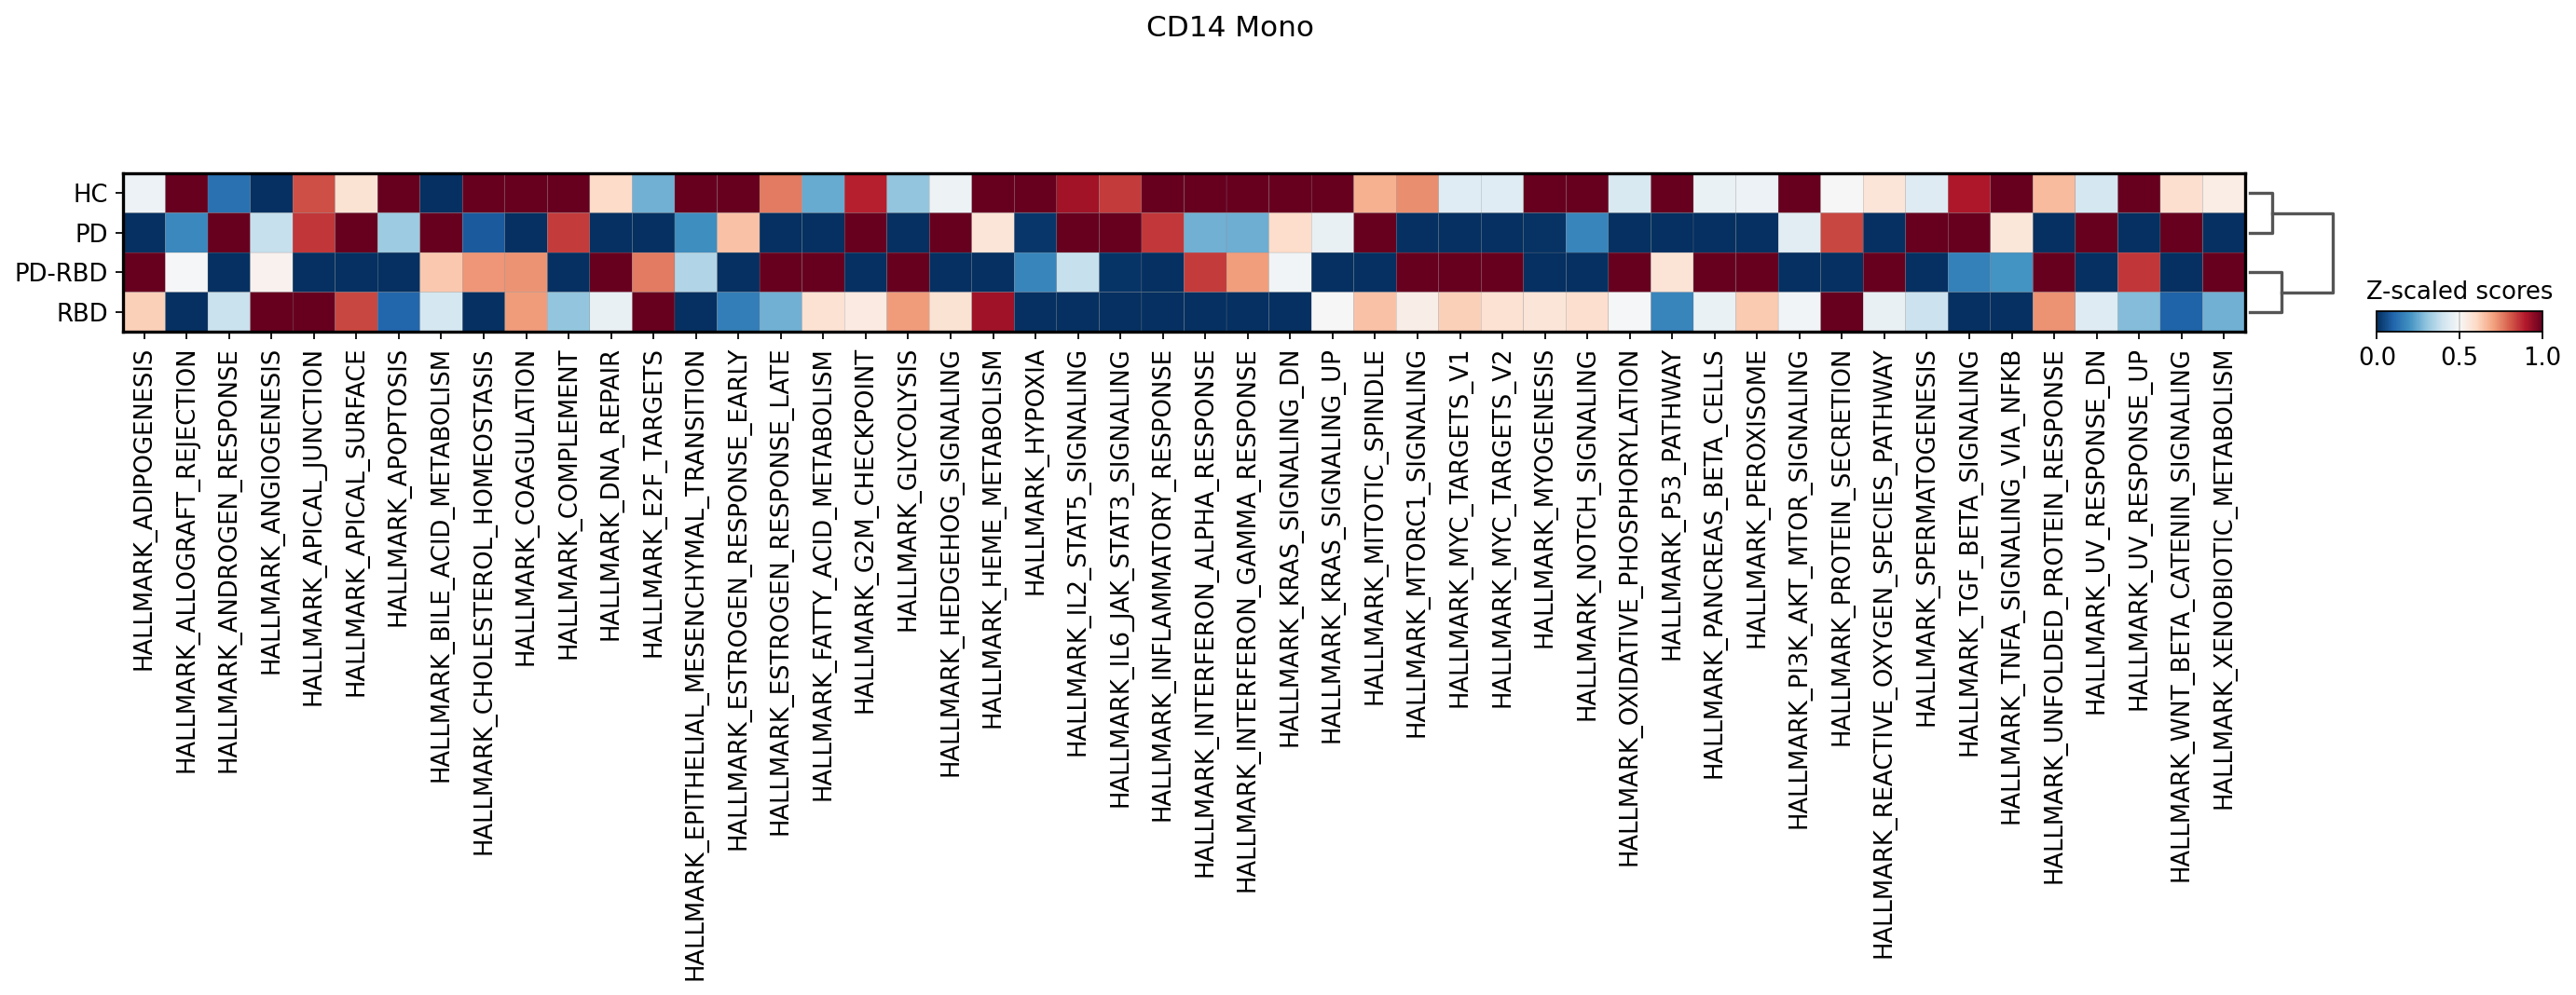

In [12]:
sc.pl.matrixplot(acts[acts.obs['cluster_L2']=='CD14 Mono'], var_names=acts.var_names, 
groupby='EnrollmentCategory', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', title='CD14 Mono')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_EnrollmentCategory']`


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:193: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat


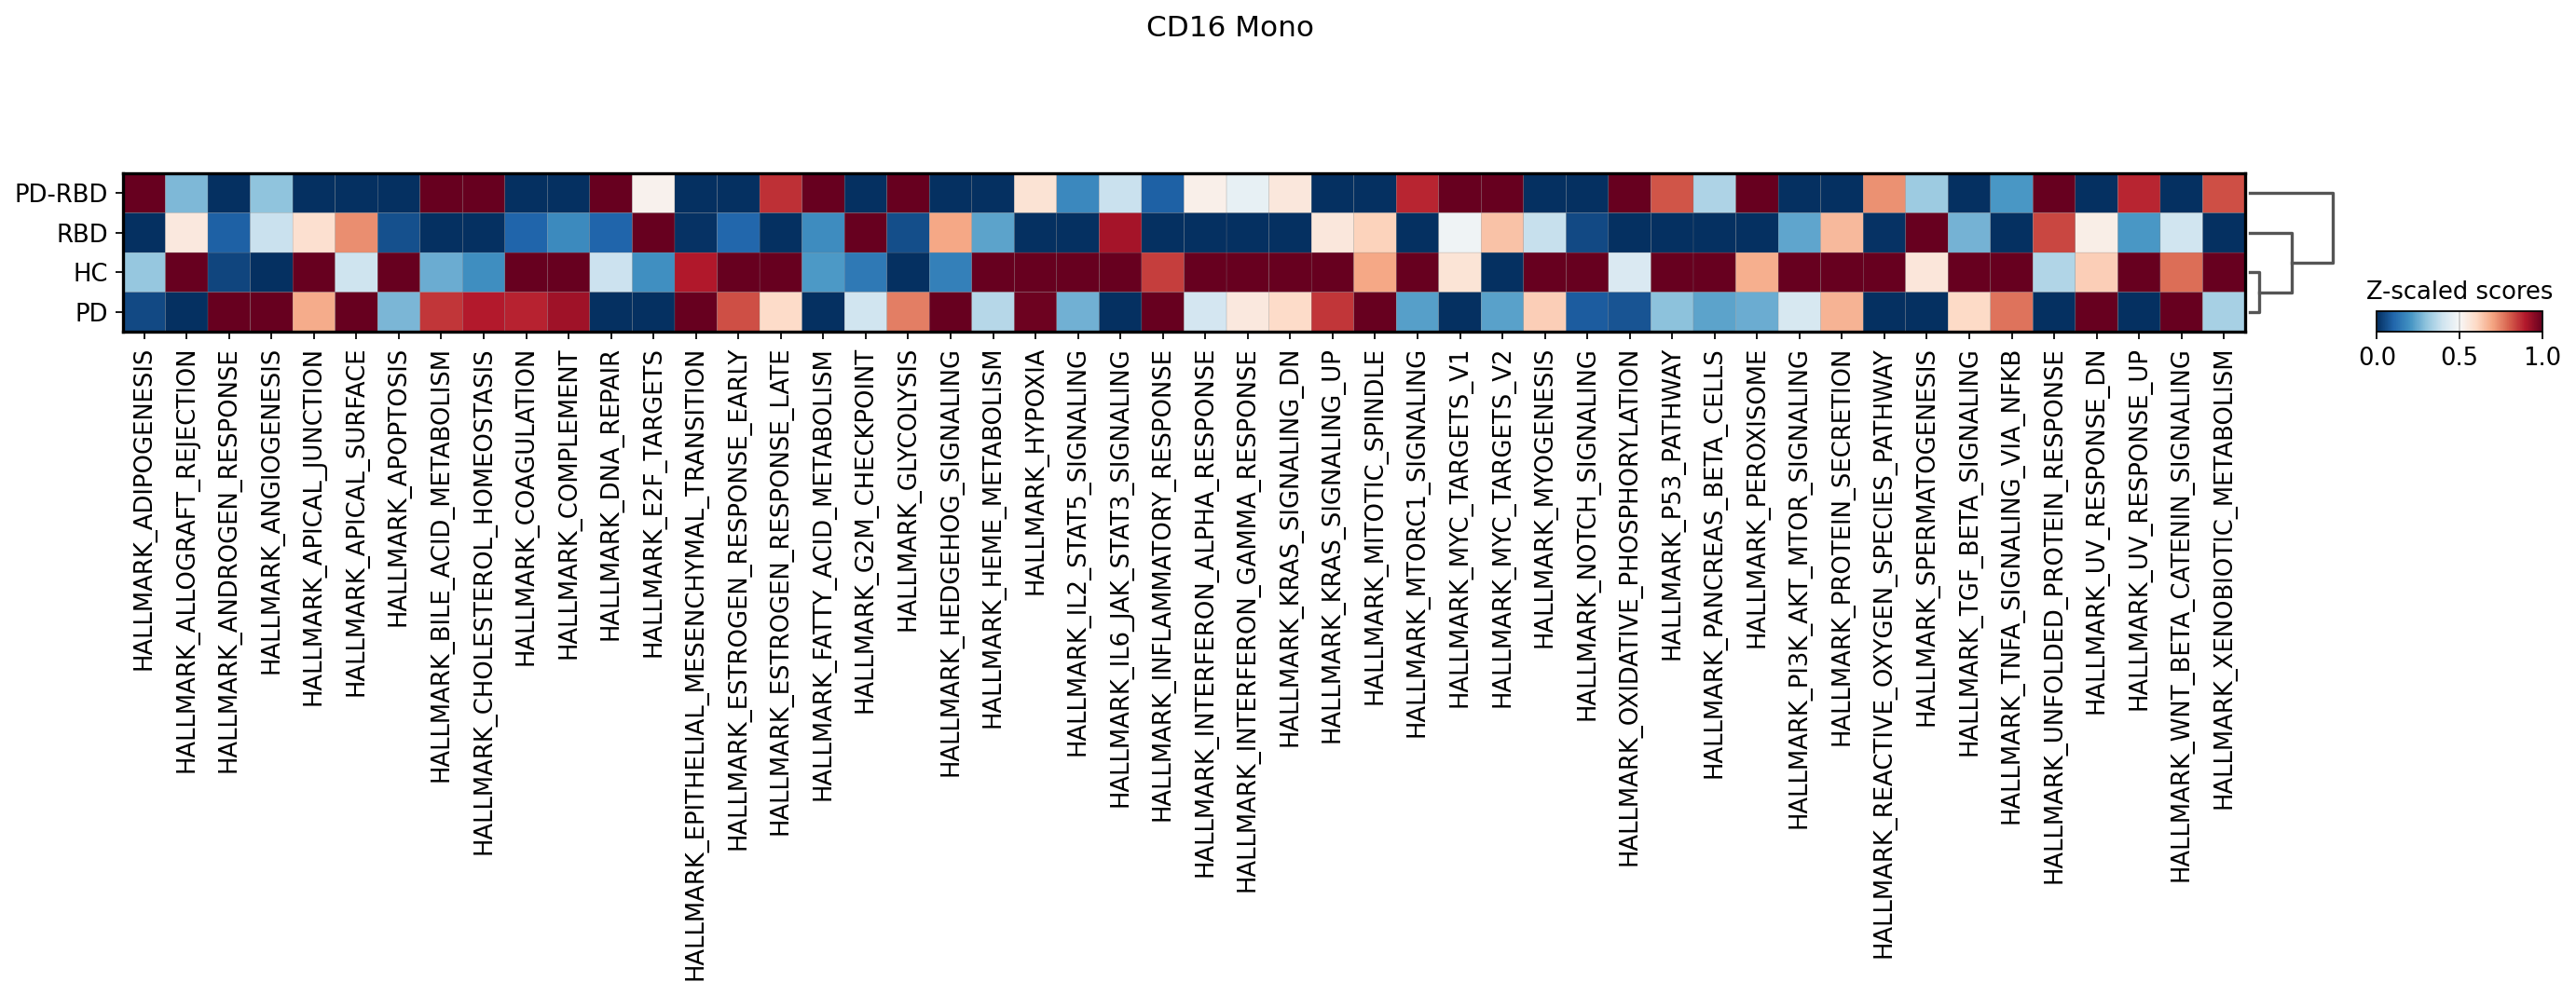

In [13]:
sc.pl.matrixplot(acts[acts.obs['cluster_L2']=='CD16 Mono'], var_names=acts.var_names, 
groupby='EnrollmentCategory', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', title='CD16 Mono')

    using data matrix X directly
Storing dendrogram info using `.uns['dendrogram_EnrollmentCategory']`


/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/scanpy/tools/_dendrogram.py:193: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = dat


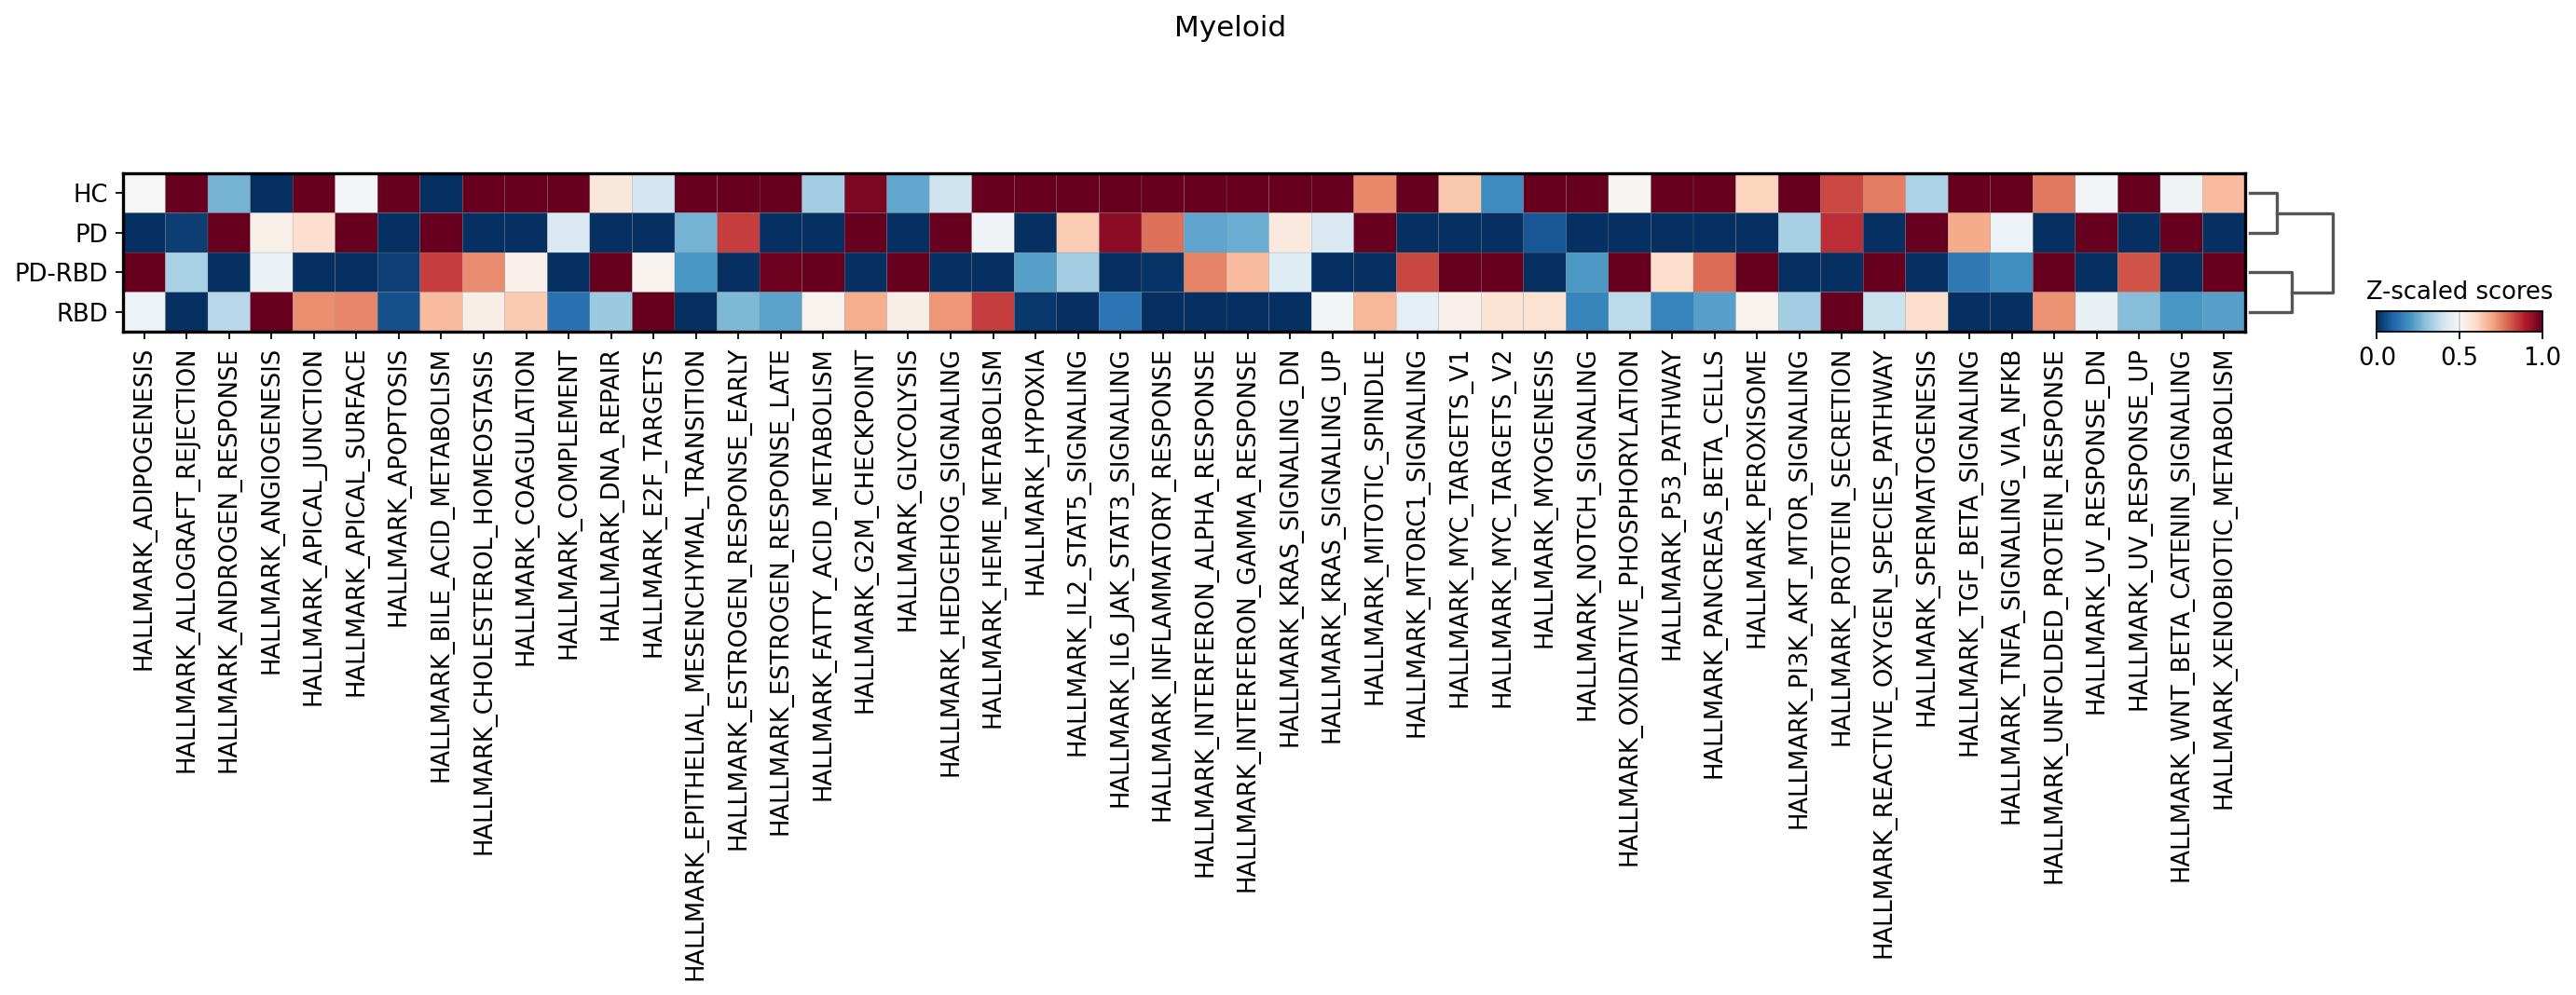

In [14]:
sc.pl.matrixplot(acts[acts.obs['cluster_L1']=='Myeloid'], var_names=acts.var_names, 
groupby='EnrollmentCategory', dendrogram=True, standard_scale='var',
                 colorbar_title='Z-scaled scores', cmap='RdBu_r', title='Myeloid')

In [7]:
list_res = []
for clu in adata.obs['cluster_L2'].cat.categories:
    d = dc.rank_sources_groups(acts[acts.obs['cluster_L2']==clu], groupby='Diagnosis_RBDstrat', reference='HC', method='t-test_overestim_var')
    d['celltype'] = clu
    list_res.append(d)
df_res = pd.concat(list_res)
df_res.to_csv(f'../scanpy/{version}/graph/significant_adjusted_pvalues_by_celltype.csv')

In [18]:
df_res.to_csv(f'../scanpy/{version}/graph/significant_adjusted_pvalues_by_celltype.csv')

In [6]:
list_celltypes_retain = list(adata.obs['cluster_L2'].value_counts()[adata.obs['cluster_L2'].value_counts() > 1000].index)

In [7]:
list_celltypes_retain

['CD14 Mono',
 'CD4 Tnaive',
 'CD4 Tcm',
 'NK CD16',
 'CD4 Tem',
 'CD8CD4 Temra',
 'CD8 Tem',
 'B naive',
 'Treg',
 'CD16 Mono',
 'CD8 Tnaive',
 'B memory',
 'MAIT',
 'Tgd',
 'cDC2',
 'NK CD56',
 'ABC',
 'pDC',
 'NK Cycling']

In [13]:
import matplotlib.lines as mlines

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_3944422/3913899145.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['neg_log10_pvals_adj'] = -np.log10(df_plot['pvals_adj'])
/tmp/ipykernel_3944422/3913899145.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_plot['neg_log10_pvals_adj'] = df_plot['neg_log10_pv

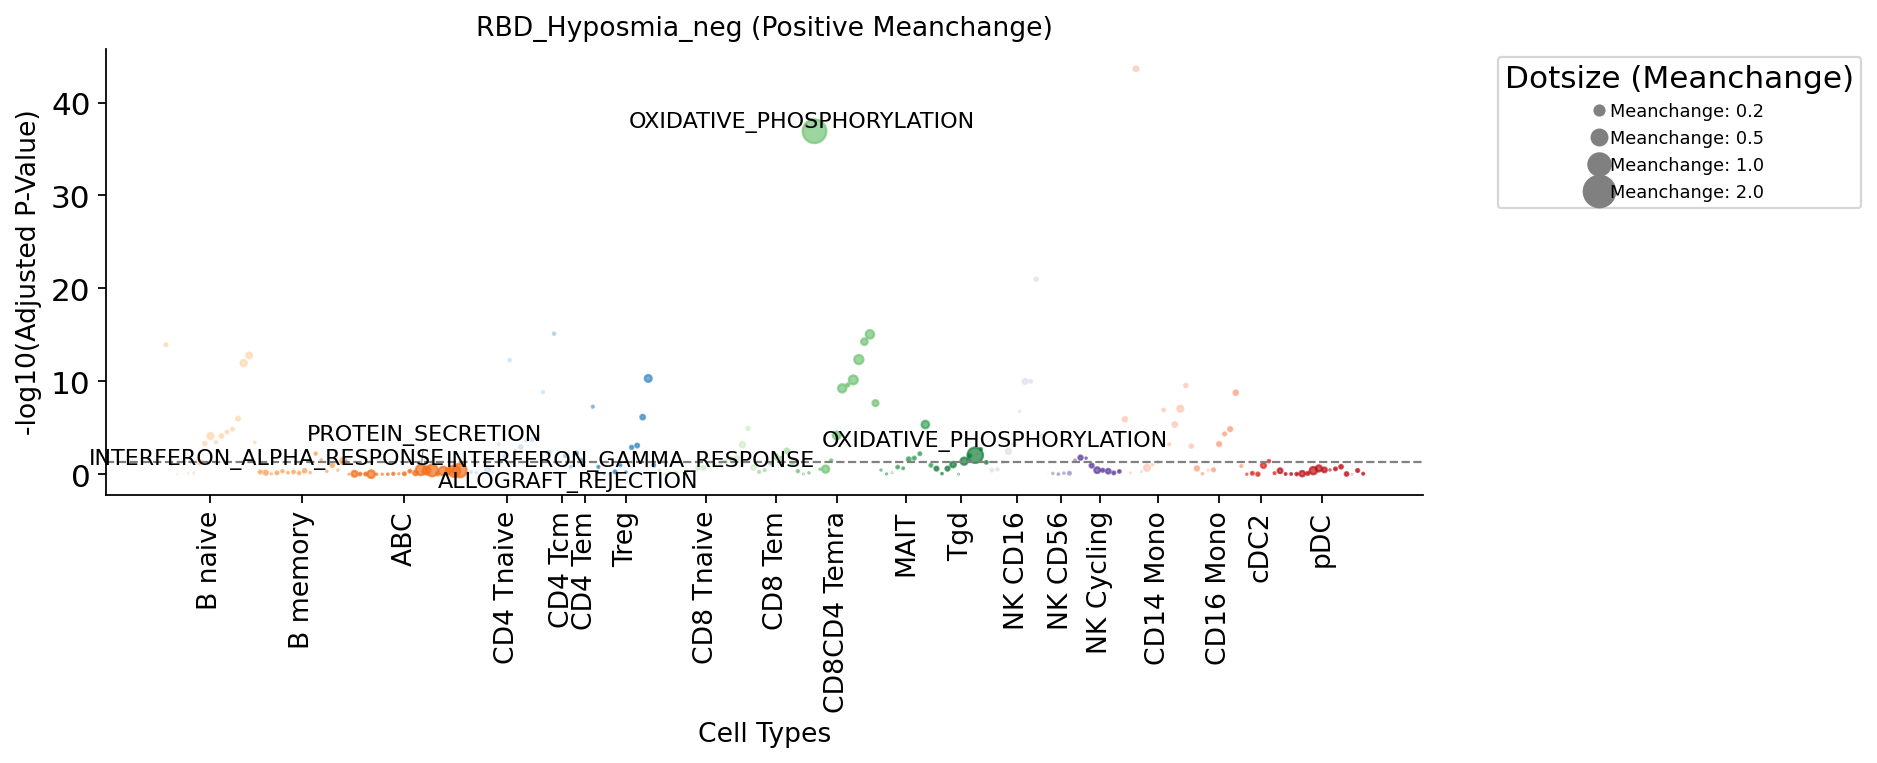

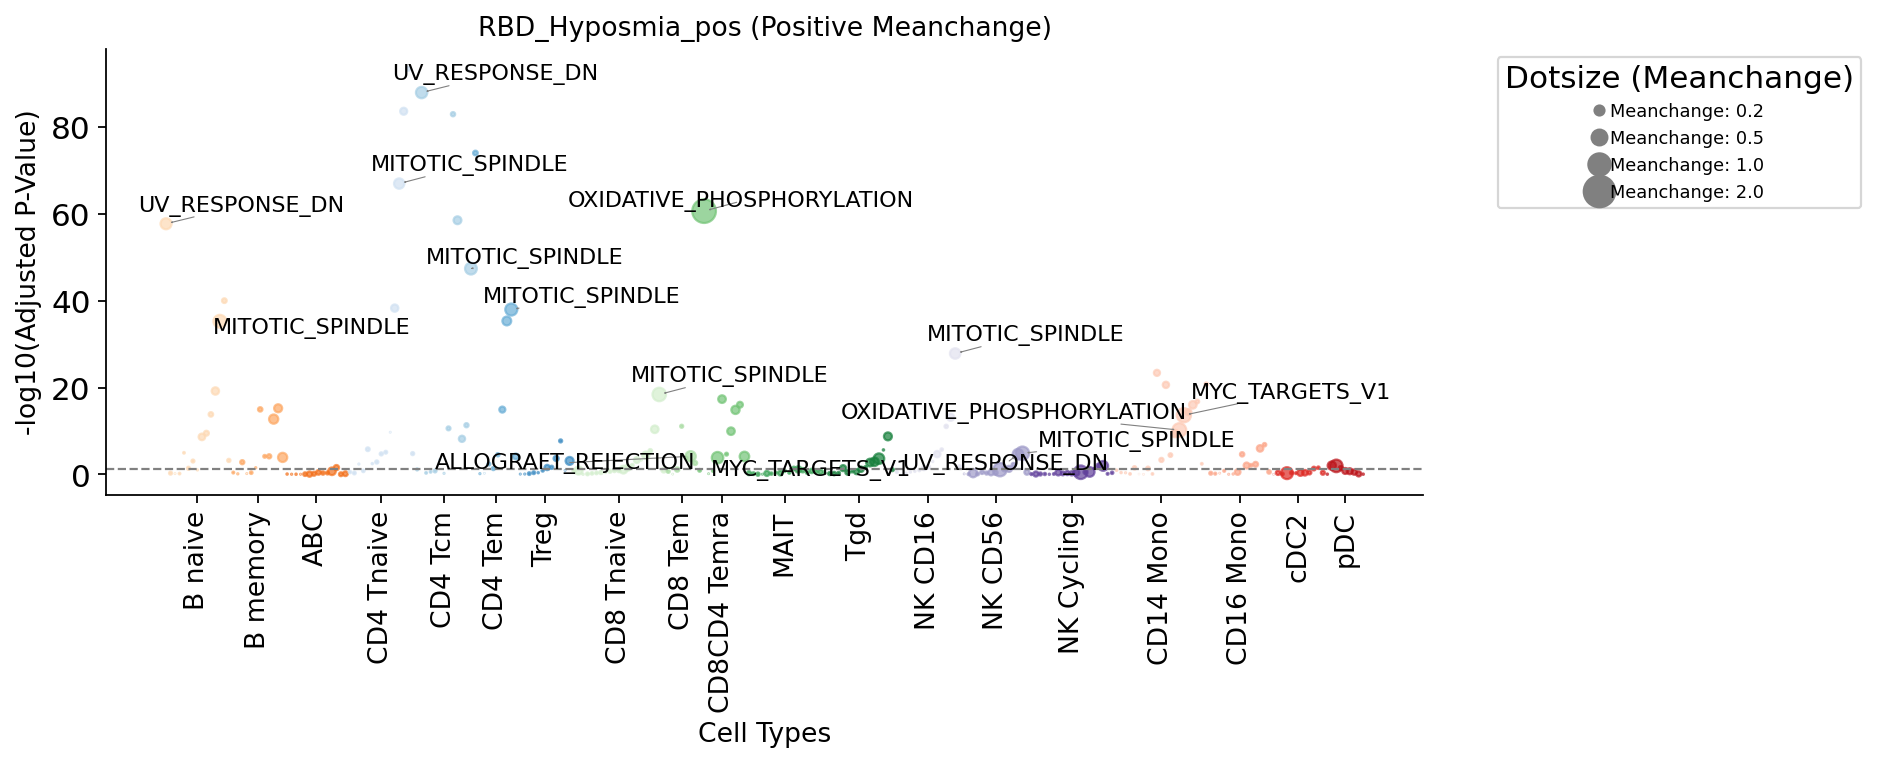

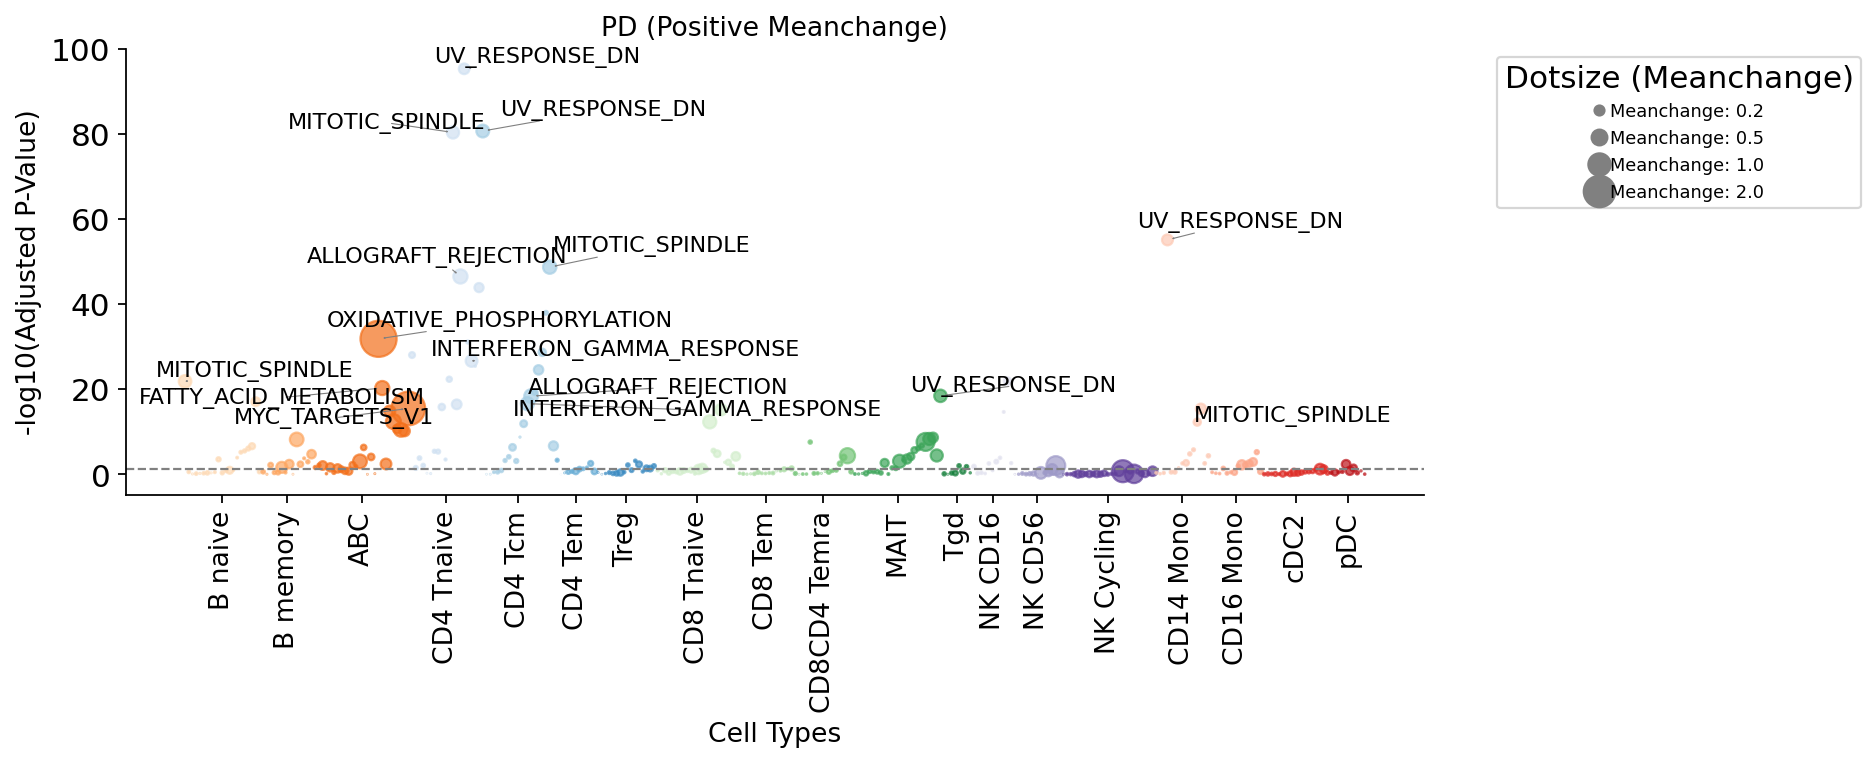

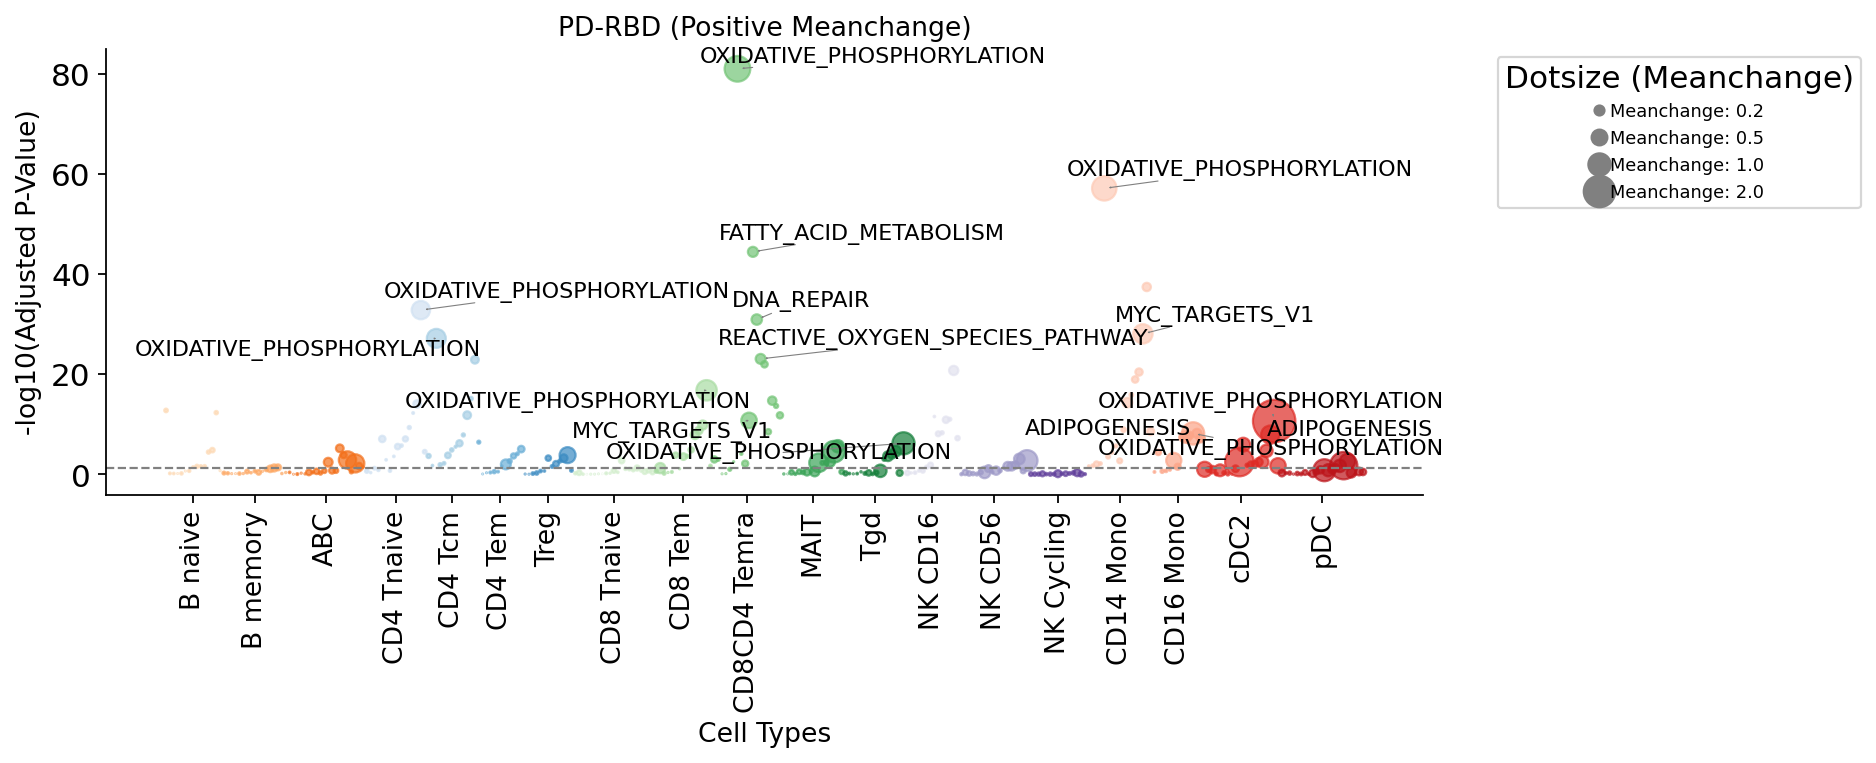

In [13]:
for group in ['RBD_Hyposmia_neg', 'RBD_Hyposmia_pos', 'PD', 'PD-RBD']:
    df_plot = df_res[df_res['group'] == group]

    df_plot['neg_log10_pvals_adj'] = -np.log10(df_plot['pvals_adj'])
    # if meanchange is negative, we need to invert the p-value
    df_plot['neg_log10_pvals_adj'] = df_plot['neg_log10_pvals_adj'] * np.sign(df_plot['meanchange'])

    color_map = {
        'B naive': '#fdd9b4',
        'B memory': '#fda762',
        'ABC': '#f3701b',
        'ASC': '#c54102',
        'CD4 Tnaive': '#d0e1f2',
        'CD4 Tcm': '#a6cee4',
        'CD4 Tem': '#6aaed6',
        'Treg': '#3b8bc2',
        'CD8 Tnaive': '#d3eecd',
        'CD8 Tem': '#a9dca3',
        'CD8CD4 Temra': '#73c476',
        'MAIT': '#3ba458',
        'T Cycling': '#1764ab',
        'Tgd': '#157f3b',
        'NK CD16': '#e2e2ef',
        'NK CD56': '#9e9ac8',
        'NK Cycling': '#61409b',
        'CD14 Mono': '#fdcab5',
        'CD16 Mono': '#fca588',
        'CD16 Mono C1': '#fb7d5d',
        'cDC1': '#f5533b',
        'cDC2': '#de2b25',
        'pDC': '#bc141a',
        'HPSC': '#808080'
    }
    df_plot = df_plot[df_plot['celltype'].isin(list_celltypes_retain)]
    df_plot['celltype'] = pd.Categorical(df_plot['celltype'], 
        categories=[x for x in adata.obs['cluster_L2'].cat.categories if x in list_celltypes_retain], ordered=True)

    df_plot = df_plot.sort_values('celltype')
    df_plot['position'] = range(len(df_plot))

    # Number of top hallmarks to label
    top_n = 15  # For positive meanchange

    df_plot['names'] = df_plot['names'].str.replace('HALLMARK_', '')

    # Filter for positive meanchange
    df_positive = df_plot[df_plot['meanchange'] > 0]

    # Map positions to celltypes for x-axis labeling
    df_positive = df_positive.sort_values('celltype')
    df_positive['position'] = range(len(df_positive))


    # Select top_n from positive meanchange
    df_top_labels = df_positive[df_positive['meanchange']>0.2].nsmallest(top_n, 'pvals_adj')

    # Get unique cell types and their approximate positions
    celltype_positions = df_positive.groupby('celltype')['position'].median()

    plt.figure(figsize=(12, 5))

    # Plot data
    for celltype, group_data in df_positive.groupby('celltype'):
        plt.scatter(
            group_data['position'],
            group_data['neg_log10_pvals_adj'],
            label=celltype,
            color=color_map.get(celltype, '#000000'),
            s=group_data['meanchange'] * 100,  # Use meanchange-based size
            alpha=0.7  # Add transparency for better visibility
        )

    # Add FDR threshold line
    plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=1, label='FDR Threshold (0.05)')

    # Add labels for top hallmarks
    texts = []
    for _, row in df_top_labels.iterrows():
        # Adjust text to match points
        texts.append(plt.text(
            row['position'],
            row['neg_log10_pvals_adj'],
            row['names'],
            fontsize=10,
            color='k',
            ha='center'  # Align center to avoid offset
        ))

    adjust_text(texts, arrowprops=dict(arrowstyle='->', color='gray', lw=0.5))

    # Customize x-axis to show one label per celltype
    plt.xticks(
        ticks=celltype_positions,
        labels=celltype_positions.index,
        rotation=90,
        fontsize=12
    )

    # Turn grid off
    plt.grid(False)

    # Final plot customization
    plt.xlabel('Cell Types', fontsize=12)
    plt.ylabel('-log10(Adjusted P-Value)', fontsize=12)
    plt.title(f'{group} (Positive Meanchange)', fontsize=12)
    # Create a custom legend for dotsize
    dot_sizes = [20, 50, 100, 200]  # Example sizes for legend
    size_labels = ['0.2', '0.5', '1.0', '2.0']  # Corresponding `meanchange` values
    legend_handles = [
        mlines.Line2D([], [], color='gray', marker='o', linestyle='None', markersize=np.sqrt(size), label=f'Meanchange: {label}')
        for size, label in zip(dot_sizes, size_labels)
    ]
    plt.legend(handles=legend_handles, title="Dotsize (Meanchange)", bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    plt.tight_layout()
    sns.despine()
    plt.savefig(f'../scanpy/{version}/graph/hallmark_manhattan_{group}.pdf', dpi=300, bbox_inches='tight')

In [17]:
list_res = []
for clu in adata.obs['cluster_L2'].cat.categories:
    d = dc.rank_sources_groups(acts[acts.obs['cluster_L2']==clu], groupby='EnrollmentCategory', reference='HC', method='t-test_overestim_var')
    d['celltype'] = clu
    list_res.append(d)
df_res = pd.concat(list_res)
df_res.to_csv(f'../scanpy/{version}/graph/significant_adjusted_pvalues_by_celltype_enrollmentcategory.csv')

In [11]:
df_res = pd.read_csv(f'../scanpy/241028_BLD_downstream/graph/significant_adjusted_pvalues_by_celltype_enrollmentcategory.csv', index_col=0)

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/tmp/ipykernel_2782759/3278860858.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_positive = df_positive.groupby('celltype', group_keys=False).apply(
/tmp/ipykernel_2782759/3278860858.py:23: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_positive = df_positive.groupby('celltype', g

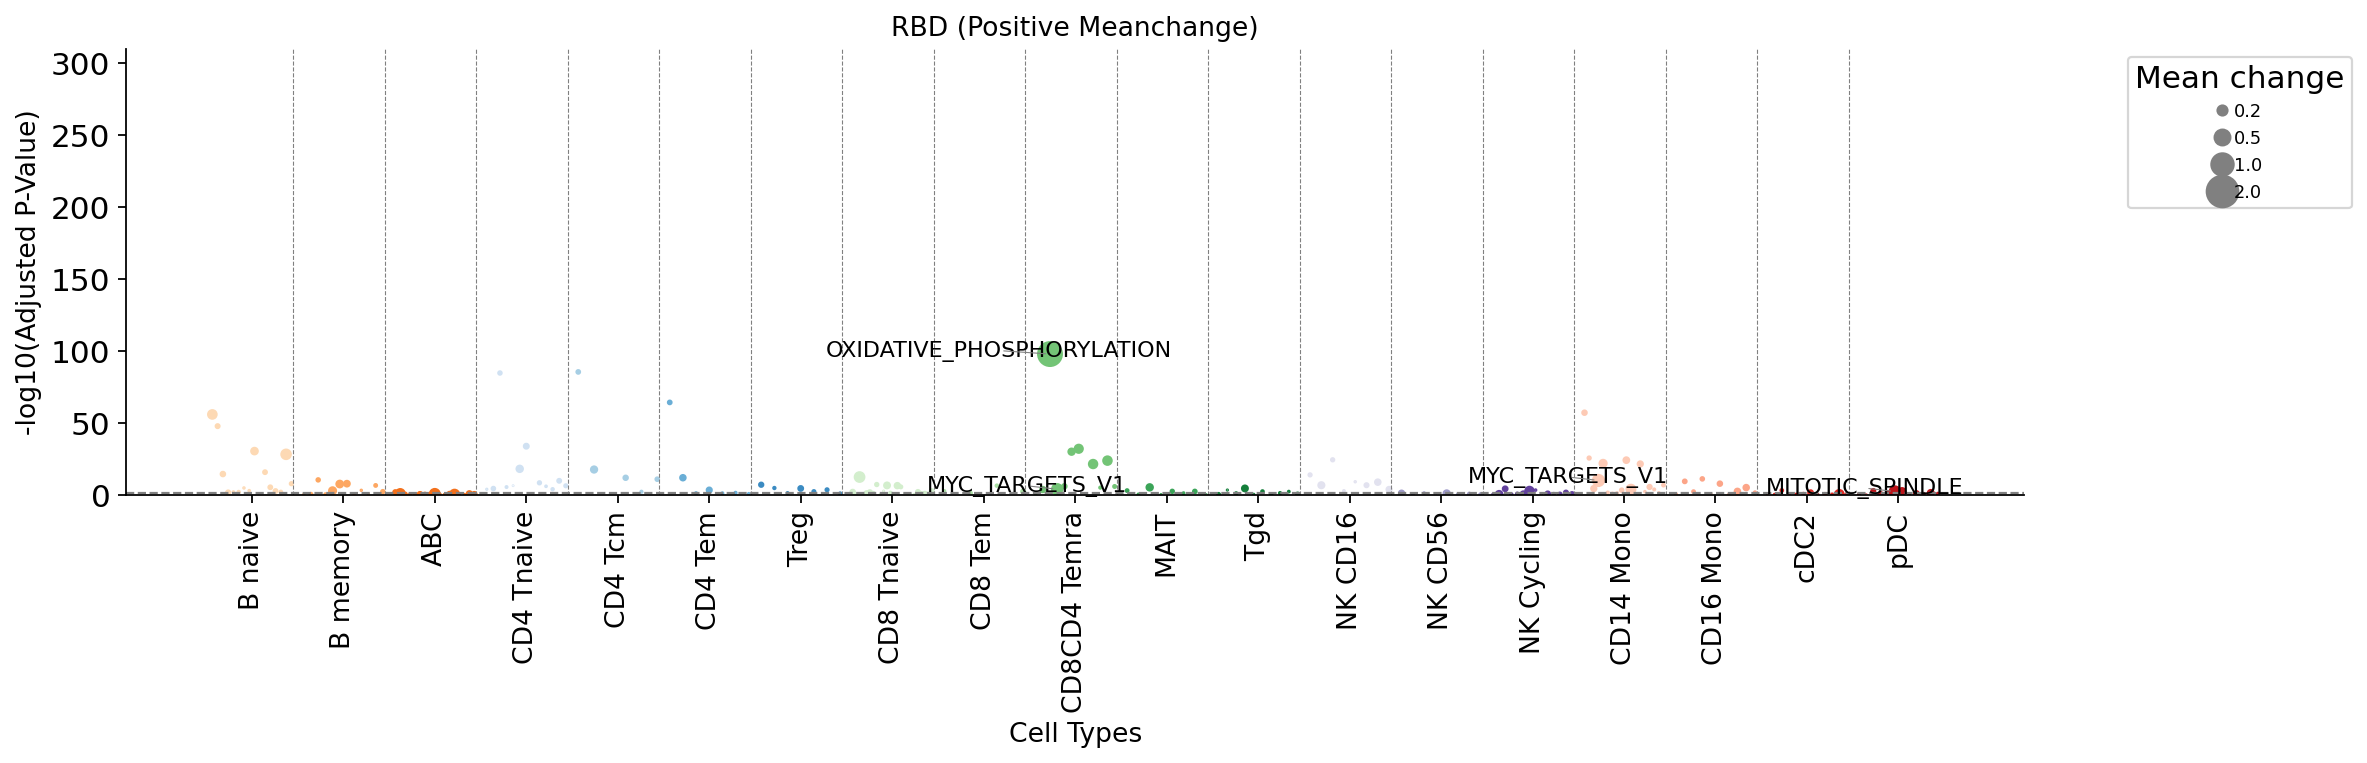

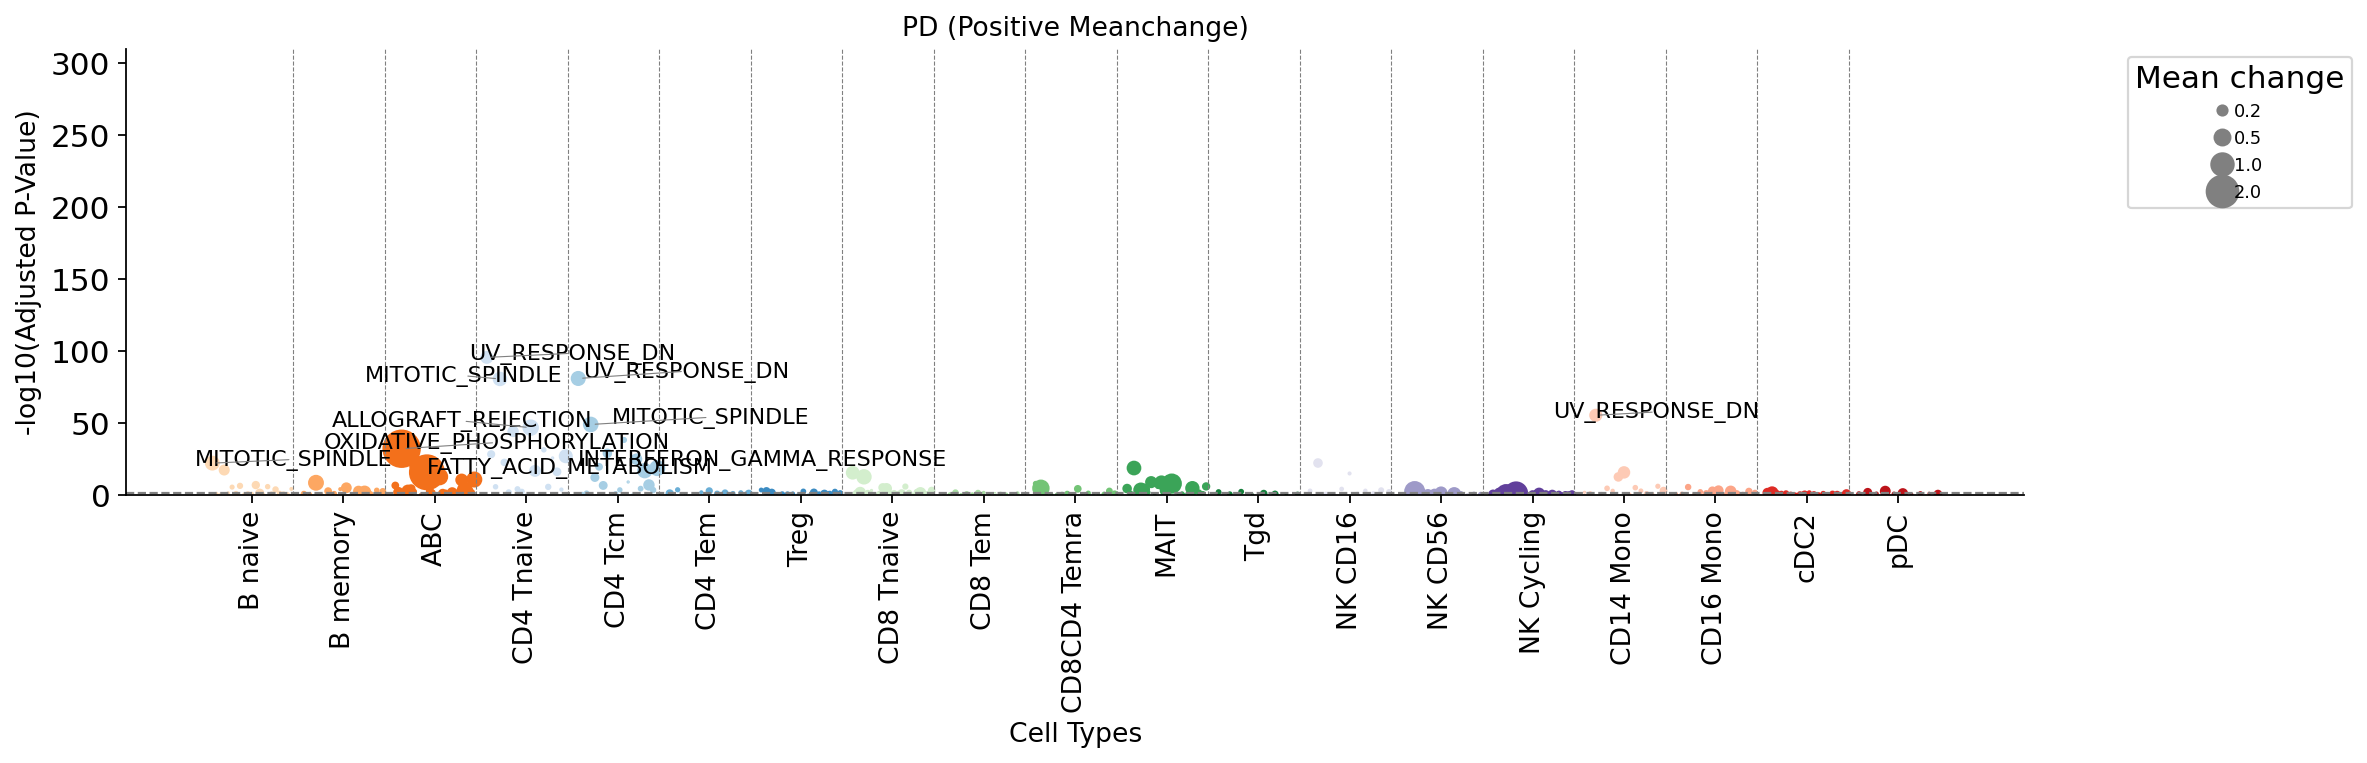

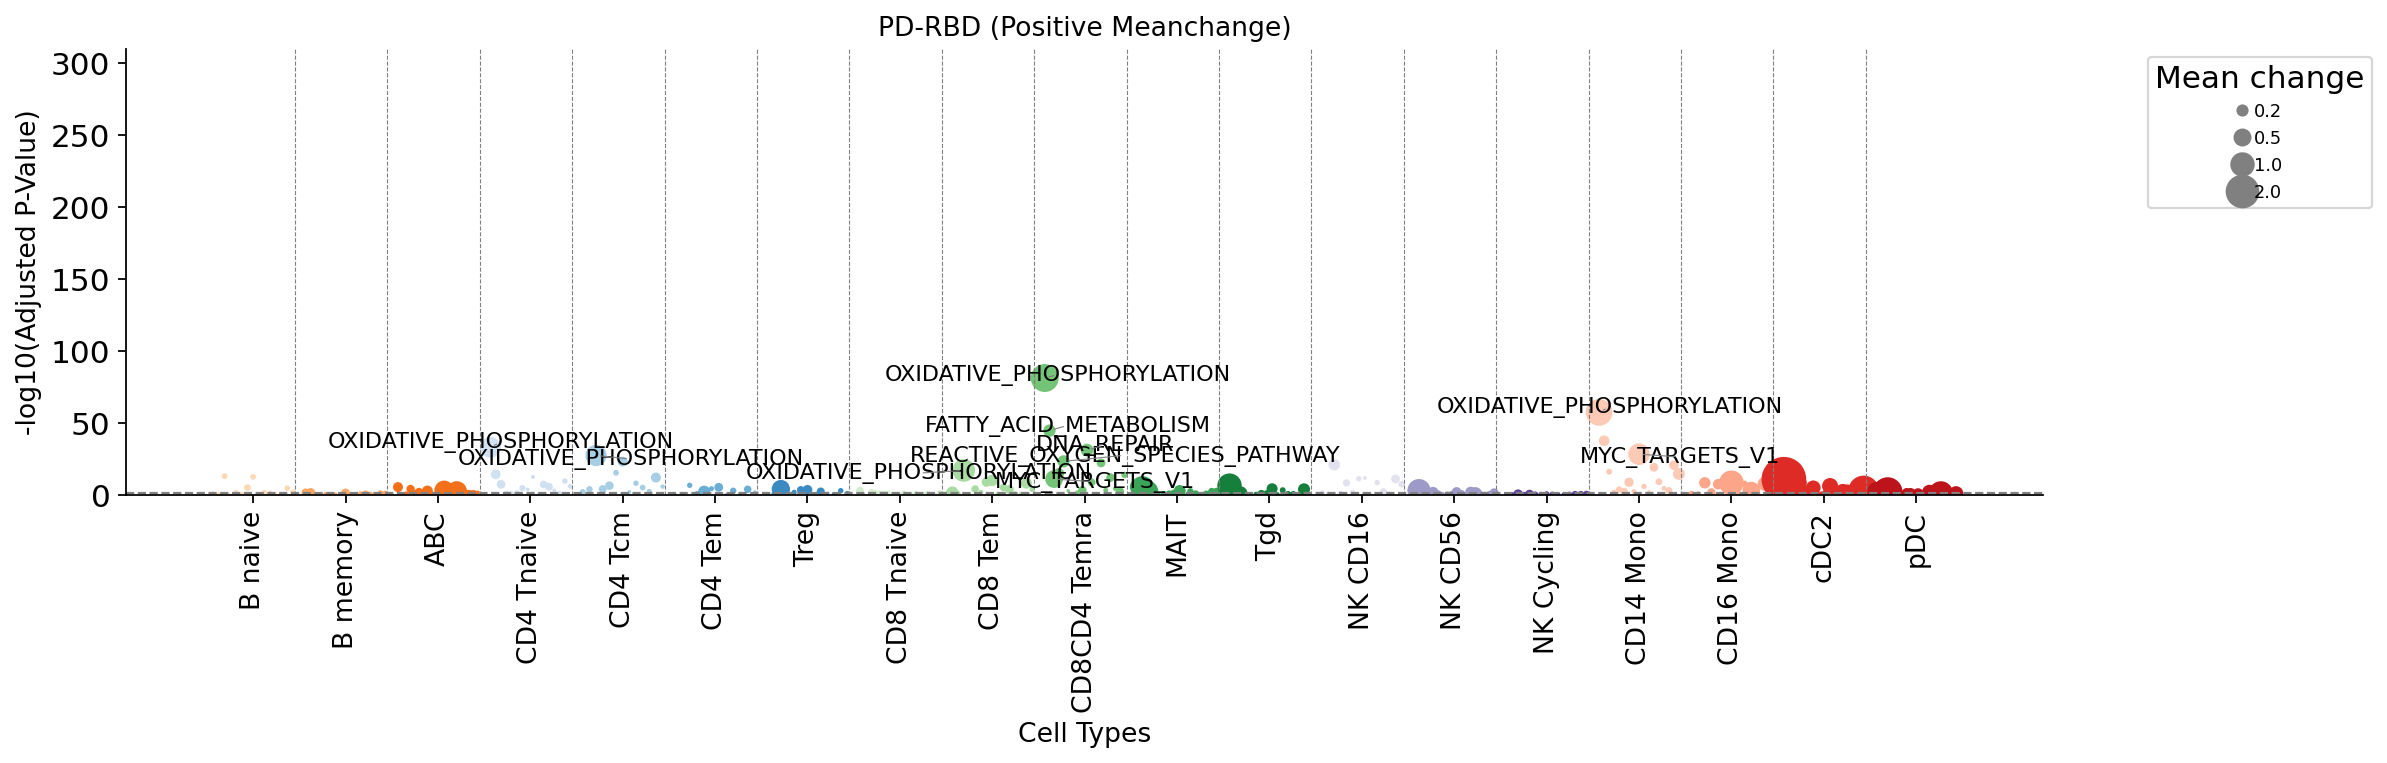

In [16]:
# group = 'RBD'
for group in ['RBD', 'PD', 'PD-RBD']:
    df_plot = df_res[df_res['group'] == group].copy()

    # Calculate -log10 adjusted p-values and set sign by meanchange
    df_plot['neg_log10_pvals_adj'] = -np.log10(df_plot['pvals_adj']) * np.sign(df_plot['meanchange'])

    # Filter relevant celltypes
    df_plot = df_plot[df_plot['celltype'].isin(list_celltypes_retain)]
    df_plot['celltype'] = pd.Categorical(
        df_plot['celltype'],
        categories=pd.unique(df_plot['celltype']),
        ordered=True
    )

    # Remove 'HALLMARK_' prefix from names
    df_plot['names'] = df_plot['names'].str.replace('HALLMARK_', '', regex=False)

    # Keep only positive meanchange rows
    df_positive = df_plot[df_plot['meanchange'] > 0].copy()

    # Shuffle rows within each celltype group
    df_positive = df_positive.groupby('celltype', group_keys=False).apply(
        lambda x: x.sample(frac=1, random_state=42)
    ).reset_index(drop=True)

    # Assign x-axis positions with equal width per celltype
    slots_per_celltype = 20  # Equal width for each celltype block
    gap = 2
    start_position = 0
    celltype_boundaries = []
    celltype_ticks = {}

    for celltype in df_positive['celltype'].unique():
        mask = df_positive['celltype'] == celltype
        n = mask.sum()
        indices = np.linspace(start_position, start_position + slots_per_celltype - 1, n)
        df_positive.loc[mask, 'position'] = indices
        celltype_boundaries.append(start_position + slots_per_celltype - 0.5)
        celltype_ticks[celltype] = start_position + (slots_per_celltype - 1) / 2
        start_position += slots_per_celltype + gap

    celltype_ticks = pd.Series(celltype_ticks)

    # Select top_n labels again from shuffled df_positive
    top_n = 10
    df_top_labels = df_positive[df_positive['meanchange'] > 0.2].nsmallest(top_n, 'pvals_adj')

    # Plotting
    plt.figure(figsize=(15, 5))
    for celltype, group_data in df_positive.groupby('celltype'):
        plt.scatter(
            group_data['position'],
            group_data['neg_log10_pvals_adj'],
            label=celltype,
            color=color_map.get(celltype, '#000000'),
            s=group_data['meanchange'] * 100,
            alpha=1
        )

    # Add FDR threshold line
    plt.axhline(y=-np.log10(0.05), color='gray', linestyle='--', linewidth=1, label='FDR Threshold (0.05)')

    # Add celltype boundary lines
    for boundary in celltype_boundaries[:-1]:
        plt.axvline(x=boundary, color='gray', linestyle='--', linewidth=0.5)

    # Add hallmark text labels
    texts = []
    for _, row in df_top_labels.iterrows():
        texts.append(plt.text(
            row['position'],
            row['neg_log10_pvals_adj'],
            row['names'],
            fontsize=10,
            color='k',
            ha='center'
        ))

    adjust_text(texts, arrowprops=dict(arrowstyle='-', color='gray', lw=0.5), expand_points=(2, 2))

    # X-axis ticks with celltype names
    plt.xticks(
        ticks=celltype_ticks,
        labels=celltype_ticks.index,
        rotation=90,
        fontsize=12
    )

    plt.xlabel('Cell Types', fontsize=12)
    plt.ylabel('-log10(Adjusted P-Value)', fontsize=12)
    plt.title(f'{group} (Positive Meanchange)', fontsize=12)

    # Create a dot size legend
    dot_sizes = [20, 50, 100, 200]
    size_labels = ['0.2', '0.5', '1.0', '2.0']
    legend_handles = [
        mlines.Line2D([], [], color='gray', marker='o', linestyle='None',
                    markersize=np.sqrt(size), label=f'{label}')
        for size, label in zip(dot_sizes, size_labels)
    ]
    plt.legend(handles=legend_handles, title="Mean change",
            bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)

    plt.tight_layout()
    sns.despine()
    plt.grid(False)
    plt.ylim(0,310)

    # Save figure
    plt.savefig(f'../scanpy/{version}/graph/hallmark_manhattan_enrollment_cat_{group}.v5.pdf',
                dpi=300, bbox_inches='tight')

In [20]:
os.makedirs(f'{sc.settings.figdir}/Hallmark_samplewise', exist_ok=True)

list_res_samplewise = []
for path in acts.var_names:
    # for clu in adata.obs['cluster_L2'].cat.categories:
    for clu in list_celltypes_retain:
        d = sc.get.obs_df(acts[acts.obs['cluster_L2']==clu], keys=['EnrollmentCategory', 'DonorID', path])
        d_donor = pd.merge(d[['DonorID', path]].groupby(by='DonorID').mean(), d[['DonorID', 'EnrollmentCategory']].drop_duplicates(), on='DonorID')
        d_donor['EnrollmentCategory'] = d_donor['EnrollmentCategory'].astype('category')
        try:
            d_donor['EnrollmentCategory'] = d_donor['EnrollmentCategory'].cat.reorder_categories(['HC', 'RBD', 'PD', 'PD-RBD'])
        except:
            continue
    
        sns.swarmplot(d_donor, x='EnrollmentCategory', y=path, color='black')
        sns.boxplot(d_donor, x='EnrollmentCategory', y=path, hue='EnrollmentCategory', boxprops=dict(alpha=.3), showfliers=False)
        plt.title(clu)
        plt.xticks(rotation=90)
        sns.despine()
        plt.savefig(f'{sc.settings.figdir}/Hallmark_samplewise/Diagnosis_EnrollmentCat_{clu}_{path}.pdf', bbox_inches='tight')
        plt.close()

        # perform Mann-Whitney U test
        from scipy.stats import mannwhitneyu
        from statsmodels.stats.multitest import multipletests

        pvals = []
        for cat in ['RBD', 'PD', 'PD-RBD']:
            pvals.append(mannwhitneyu(d_donor[d_donor['EnrollmentCategory']==cat][path], d_donor[d_donor['EnrollmentCategory']=='HC'][path])[1])

        df_pvals = pd.DataFrame({'pvals': pvals, 'cat': ['RBD', 'PD', 'PD-RBD']})
        df_pvals['pvals_adj'] = multipletests(df_pvals['pvals'], method='fdr_bh')[1]
        df_pvals['path'] = path
        df_pvals['celltype'] = clu
        list_res_samplewise.append(df_pvals)

df_res_samplewise = pd.concat(list_res_samplewise)
df_res_samplewise.to_csv(f'{sc.settings.figdir}/Hallmark_samplewise/df_res_samplewise_enrollmentcat.csv')

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 9.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 21.9% of the points cannot be placed; you may want to decrease the size 

In [14]:
os.makedirs(f'{sc.settings.figdir}/Hallmark_samplewise', exist_ok=True)

list_res_samplewise = []
for path in acts.var_names:
    # for clu in adata.obs['cluster_L2'].cat.categories:
    for clu in list_celltypes_retain:
        d = sc.get.obs_df(acts[acts.obs['cluster_L2']==clu], keys=['Diagnosis_RBDstrat', 'DonorID', path])
        d_donor = pd.merge(d[['DonorID', path]].groupby(by='DonorID').mean(), d[['DonorID', 'Diagnosis_RBDstrat']].drop_duplicates(), on='DonorID')
        d_donor['Diagnosis_RBDstrat'] = d_donor['Diagnosis_RBDstrat'].astype('category')
        try:
            d_donor['Diagnosis_RBDstrat'] = d_donor['Diagnosis_RBDstrat'].cat.reorder_categories(['HC', 'RBD_Hyposmia_neg', 'RBD_Hyposmia_pos', 'PD', 'PD-RBD'])
        except:
            continue
    
        sns.swarmplot(d_donor, x='Diagnosis_RBDstrat', y=path, color='black')
        sns.boxplot(d_donor, x='Diagnosis_RBDstrat', y=path, hue='Diagnosis_RBDstrat', boxprops=dict(alpha=.3), showfliers=False)
        plt.title(clu)
        plt.xticks(rotation=90)
        sns.despine()
        plt.savefig(f'{sc.settings.figdir}/Hallmark_samplewise/Diagnosis_RBDstrat_{clu}_{path}.pdf', bbox_inches='tight')
        plt.close()

        # perform Mann-Whitney U test
        from scipy.stats import mannwhitneyu
        from statsmodels.stats.multitest import multipletests

        pvals = []
        for cat in ['RBD_Hyposmia_neg', 'RBD_Hyposmia_pos', 'PD', 'PD-RBD']:
            pvals.append(mannwhitneyu(d_donor[d_donor['Diagnosis_RBDstrat']==cat][path], d_donor[d_donor['Diagnosis_RBDstrat']=='HC'][path])[1])

        df_pvals = pd.DataFrame({'pvals': pvals, 'cat': ['RBD_Hyposmia_neg', 'RBD_Hyposmia_pos', 'PD', 'PD-RBD']})
        df_pvals['pvals_adj'] = multipletests(df_pvals['pvals'], method='fdr_bh')[1]
        df_pvals['path'] = path
        df_pvals['celltype'] = clu
        list_res_samplewise.append(df_pvals)

df_res_samplewise = pd.concat(list_res_samplewise)
df_res_samplewise.to_csv(f'{sc.settings.figdir}/Hallmark_samplewise/df_res_samplewise.csv')

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 8.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 33.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning: 11.8% of the points cannot be placed; you may want to decrease the size 

In [10]:
adata.obs['group'] = adata.obs['PD_Probability']

In [11]:
from adjustText import adjust_text

th_padj = 1e-2
th_padj_plot = 1e-200
th_lfc = 0.2
th_mean = 0.5
n_top = 50

for clu in adata.obs['cluster_L2'].unique():
    a = adata[adata.obs['cluster_L2'] == clu].copy()
    
    for dis in ['RBD-LowIntm', 'RBD-High']:
        a_dis = a[a.obs.group.isin(['HC', dis])].copy()
        sc.tl.rank_genes_groups(a_dis, "group")

        d = sc.get.rank_genes_groups_df(a_dis, dis)

        d['neg_log10_pvals_adj'] = -np.log10(d['pvals_adj'].clip(lower=th_padj_plot))
        d['mean'] = list(a_dis.to_df().mean().loc[d.names])
        d.to_csv(f'../scanpy/{version}/graph/deg_{clu}_group_{dis}.csv')
        d = d[d['mean'] > th_mean]
        
        plt.figure(figsize=(10, 6))
        plt.scatter(d['logfoldchanges'], d['neg_log10_pvals_adj'], color='grey', alpha=0.5)
        
        deg = d[(d['pvals_adj'] < th_padj) & (abs(d['logfoldchanges']) > th_lfc)]
        plt.scatter(deg['logfoldchanges'], deg['neg_log10_pvals_adj'], color='red')
        
        deg_text = deg.loc[deg.scores.abs().nlargest(n_top).index]
        texts = [plt.text(row['logfoldchanges'], row['neg_log10_pvals_adj'], row['names'], ha='right') for index, row in deg_text.iterrows()]
        if len(texts) > 0:
            adjust_text(texts, arrowprops=dict(arrowstyle='->', color='black'))
        
        plt.title(f'{clu}: Control vs {dis}')
        plt.xlabel('Log Fold Change')
        plt.ylabel('-log10 Adjusted P-Values')
        plt.axhline(-np.log10(th_padj), color='blue', linestyle='dashed')
        plt.axvline(th_lfc, color='blue', linestyle='dashed')
        plt.axvline(-th_lfc, color='blue', linestyle='dashed')
        plt.grid(True)
        sns.despine(left=True, bottom=True)
        
        plt.savefig(f'../scanpy/{version}/graph/volcano_adj_{clu}_group_{dis}.pdf', bbox_inches='tight')
        plt.close()

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:04)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by grou

## scDRS

In [13]:
df_cov = adata.obs
df_cov['const'] = 1
df_cov[['const', 'n_genes_by_counts']].to_csv(f'../scanpy/{version}/cov.tsv', sep='\t')

In [12]:
version

'241028_BLD_downstream'

## QC visualization 

In [6]:
adata

AnnData object with n_obs × n_vars = 523521 × 26640
    obs: 'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Year1stDLBSx', 'YearDLBDX', 'DLB

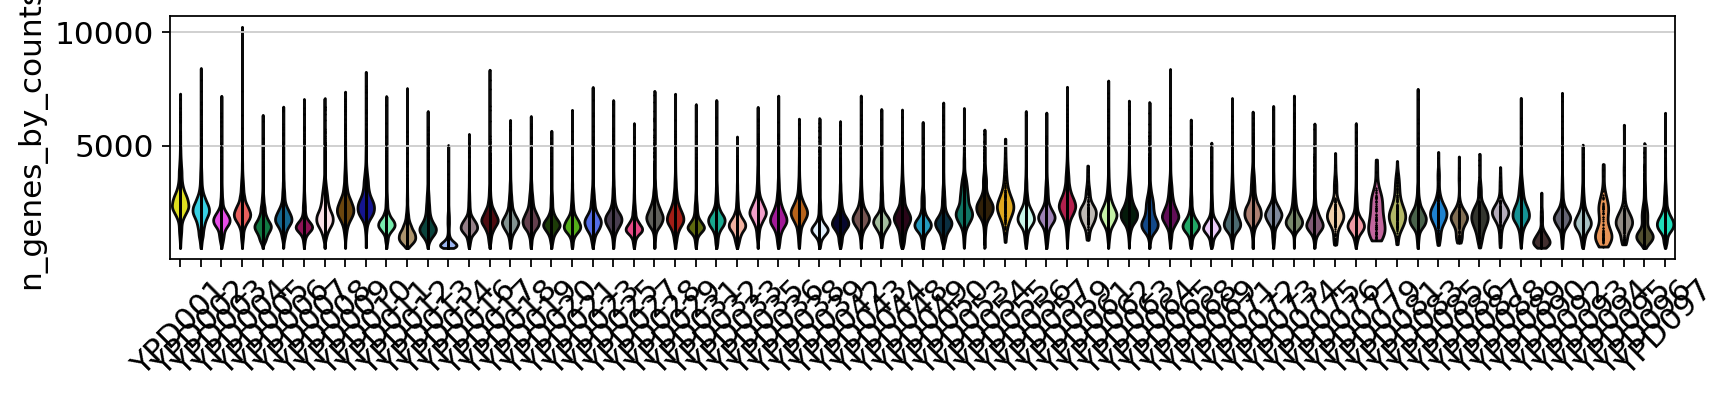

In [18]:
with plt.rc_context({"figure.figsize": (10, 2)}):
    sc.pl.violin(adata, keys=['n_genes_by_counts'], 
    groupby='DonorID', multi_panel=True, jitter=False, rotation=45, save='_QC_genes_by_counts.pdf')

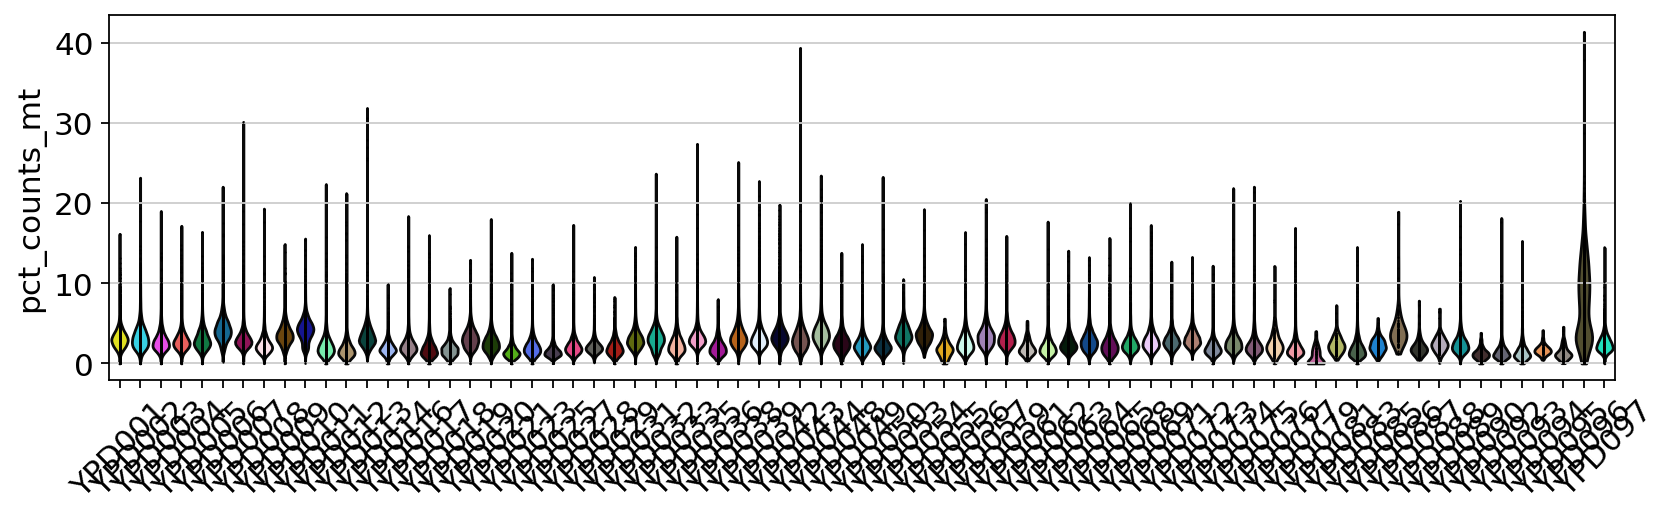

In [19]:
with plt.rc_context({"figure.figsize": (10, 3)}):
    sc.pl.violin(adata, keys=['pct_counts_mt'], 
    groupby='DonorID', multi_panel=True, jitter=False, rotation=45, save='_QC_pct_counts_mt.pdf')

In [8]:
adata.obs[['n_genes_by_counts', 'pct_counts_mt']].mean()

n_genes_by_counts    1832.839284
pct_counts_mt           2.672596
dtype: float64

In [26]:
df_qc = adata.obs[['n_genes_by_counts', 'pct_counts_mt', 'SampleID']].groupby(by='SampleID').mean()
df_qc['n_cell'] = adata.obs['SampleID'].value_counts()[df_qc.index]
df_qc = pd.merge(df_qc, adata.obs[['SampleID', 'EnrollmentCategory']].drop_duplicates(), left_index=True, right_on='SampleID').reset_index(drop=True)

In [38]:
df_qc

n_genes_by_counts  pct_counts_mt  n_cell   SampleID EnrollmentCategory
0         2579.837509       3.169045    5588  YPD001BLD                 HC
1         2174.499473       3.279699    9492  YPD002BLD                 HC
2         1760.982752       2.774422   10088  YPD003BLD                RBD
3         2126.794118       2.827293    7072  YPD004BLD                RBD
4         1578.034468       3.016732    9081  YPD005BLD                RBD
..                ...            ...     ...        ...                ...
68        1736.688619       1.376237    5360  YPD093BLD                RBD
69        1645.260870       1.696053      69  YPD094BLD                RBD
70        1693.578313       1.350603     166  YPD095BLD                 PD
71        1466.807093       7.565979    2312  YPD096BLD                RBD
72        1709.701777       2.482507    7035  YPD097BLD                RBD

[73 rows x 5 columns]

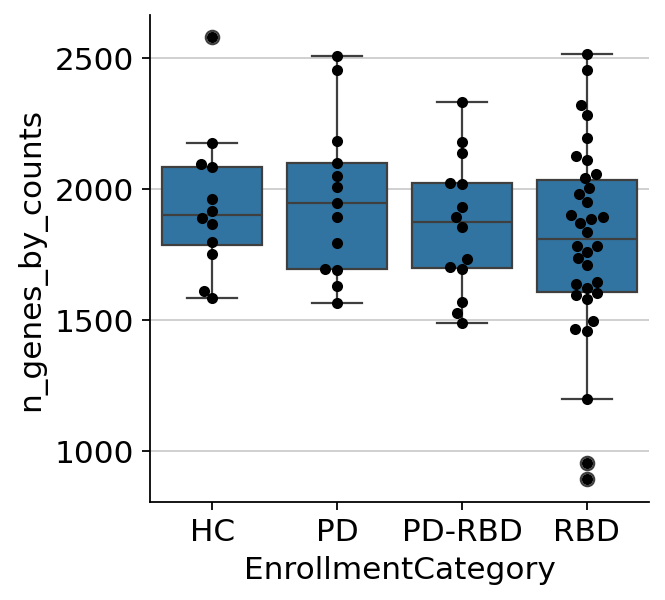

In [45]:
colors = {"HC": "gray", "RBD": "#DEA4CA", "PD": "#A567A1", "PD-RBD": "#595996"}

sns.swarmplot(data=df_qc, x='EnrollmentCategory', y='n_genes_by_counts', color='black')
sns.boxplot(data=df_qc, x='EnrollmentCategory', y='n_genes_by_counts')
sns.despine()
plt.savefig(f'../scanpy/{version}/graph/QC_n_genes_by_counts.pdf')

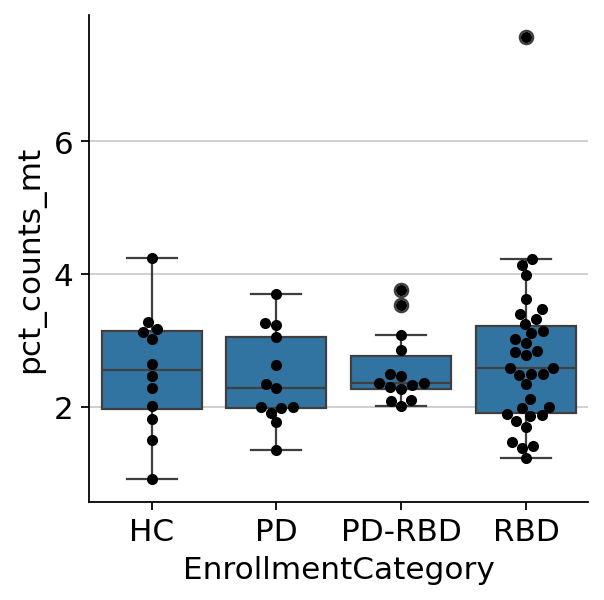

In [46]:
sns.swarmplot(data=df_qc, x='EnrollmentCategory', y='pct_counts_mt', color='black')
sns.boxplot(data=df_qc, x='EnrollmentCategory', y='pct_counts_mt')
sns.despine()
plt.savefig(f'../scanpy/{version}/graph/QC_pct_counts_mt.pdf')

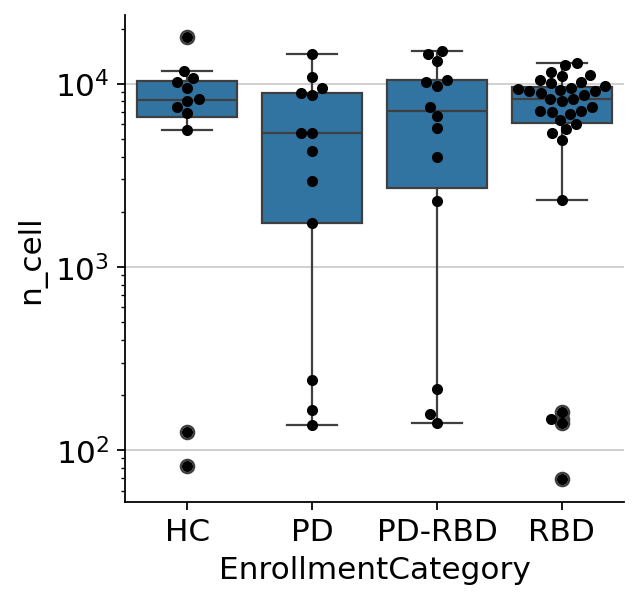

In [48]:
sns.swarmplot(data=df_qc, x='EnrollmentCategory', y='n_cell', color='black')
sns.boxplot(data=df_qc, x='EnrollmentCategory', y='n_cell')
sns.despine()
plt.yscale('log')
plt.savefig(f'../scanpy/{version}/graph/QC_n_cell.pdf')

In [4]:
adata

AnnData object with n_obs × n_vars = 523521 × 26640
    obs: 'cellranger_sample_id', 'SampleID', 'SampleType', 'DonorID', 'Estimated Number of Cells', 'Mean Reads per Cell', 'Median Genes per Cell', 'Number of Reads', 'Valid Barcodes', 'Sequencing Saturation', 'Q30 Bases in Barcode', 'Q30 Bases in RNA Read', 'Q30 Bases in UMI', 'Reads Mapped to Genome', 'Reads Mapped Confidently to Genome', 'Reads Mapped Confidently to Intergenic Regions', 'Reads Mapped Confidently to Intronic Regions', 'Reads Mapped Confidently to Exonic Regions', 'Reads Mapped Confidently to Transcriptome', 'Reads Mapped Antisense to Gene', 'Fraction Reads in Cells', 'Total Genes Detected', 'Median UMI Counts per Cell', 'Q30 Bases in RNA Read 2', 'chemistry', 'Visit', 'SubjectID', 'DateICFSigned', 'YearICFSigned', 'EnrollmentCategory', 'RBDY/N?', 'YearofRBDDx', 'RBDAAO', 'AgeRBDDx', 'RBDDxtoConesnt', 'PDY/N', 'Year1stPDSx', 'YearofPDDx', 'PDAAO', 'AgePDDx', 'PDDxtoConsent', 'DLBY/N', 'Year1stDLBSx', 'YearDLBDX', 'DLB

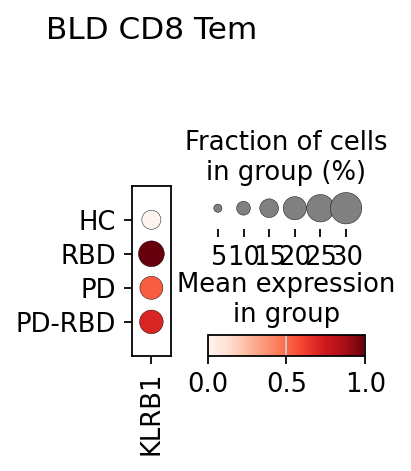

In [12]:
sc.pl.dotplot(adata[adata.obs['cluster_L2']=='CD8 Tem'], 
    var_names=['KLRB1'], groupby='EnrollmentCategory',title='BLD CD8 Tem', standard_scale='var', categories_order=['HC', 'RBD', 'PD', 'PD-RBD']
    )

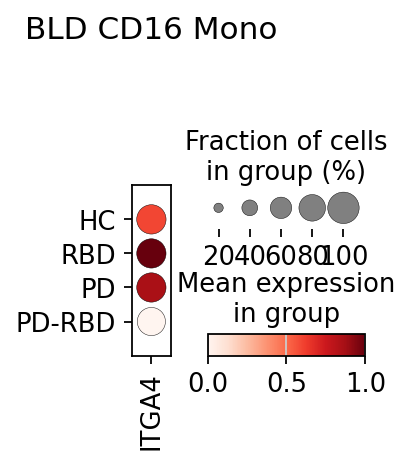

In [13]:
sc.pl.dotplot(adata[adata.obs['cluster_L2']=='CD16 Mono'], 
    var_names=['ITGA4'], groupby='EnrollmentCategory', title='BLD CD16 Mono', standard_scale='var', categories_order=['HC', 'RBD', 'PD', 'PD-RBD'])

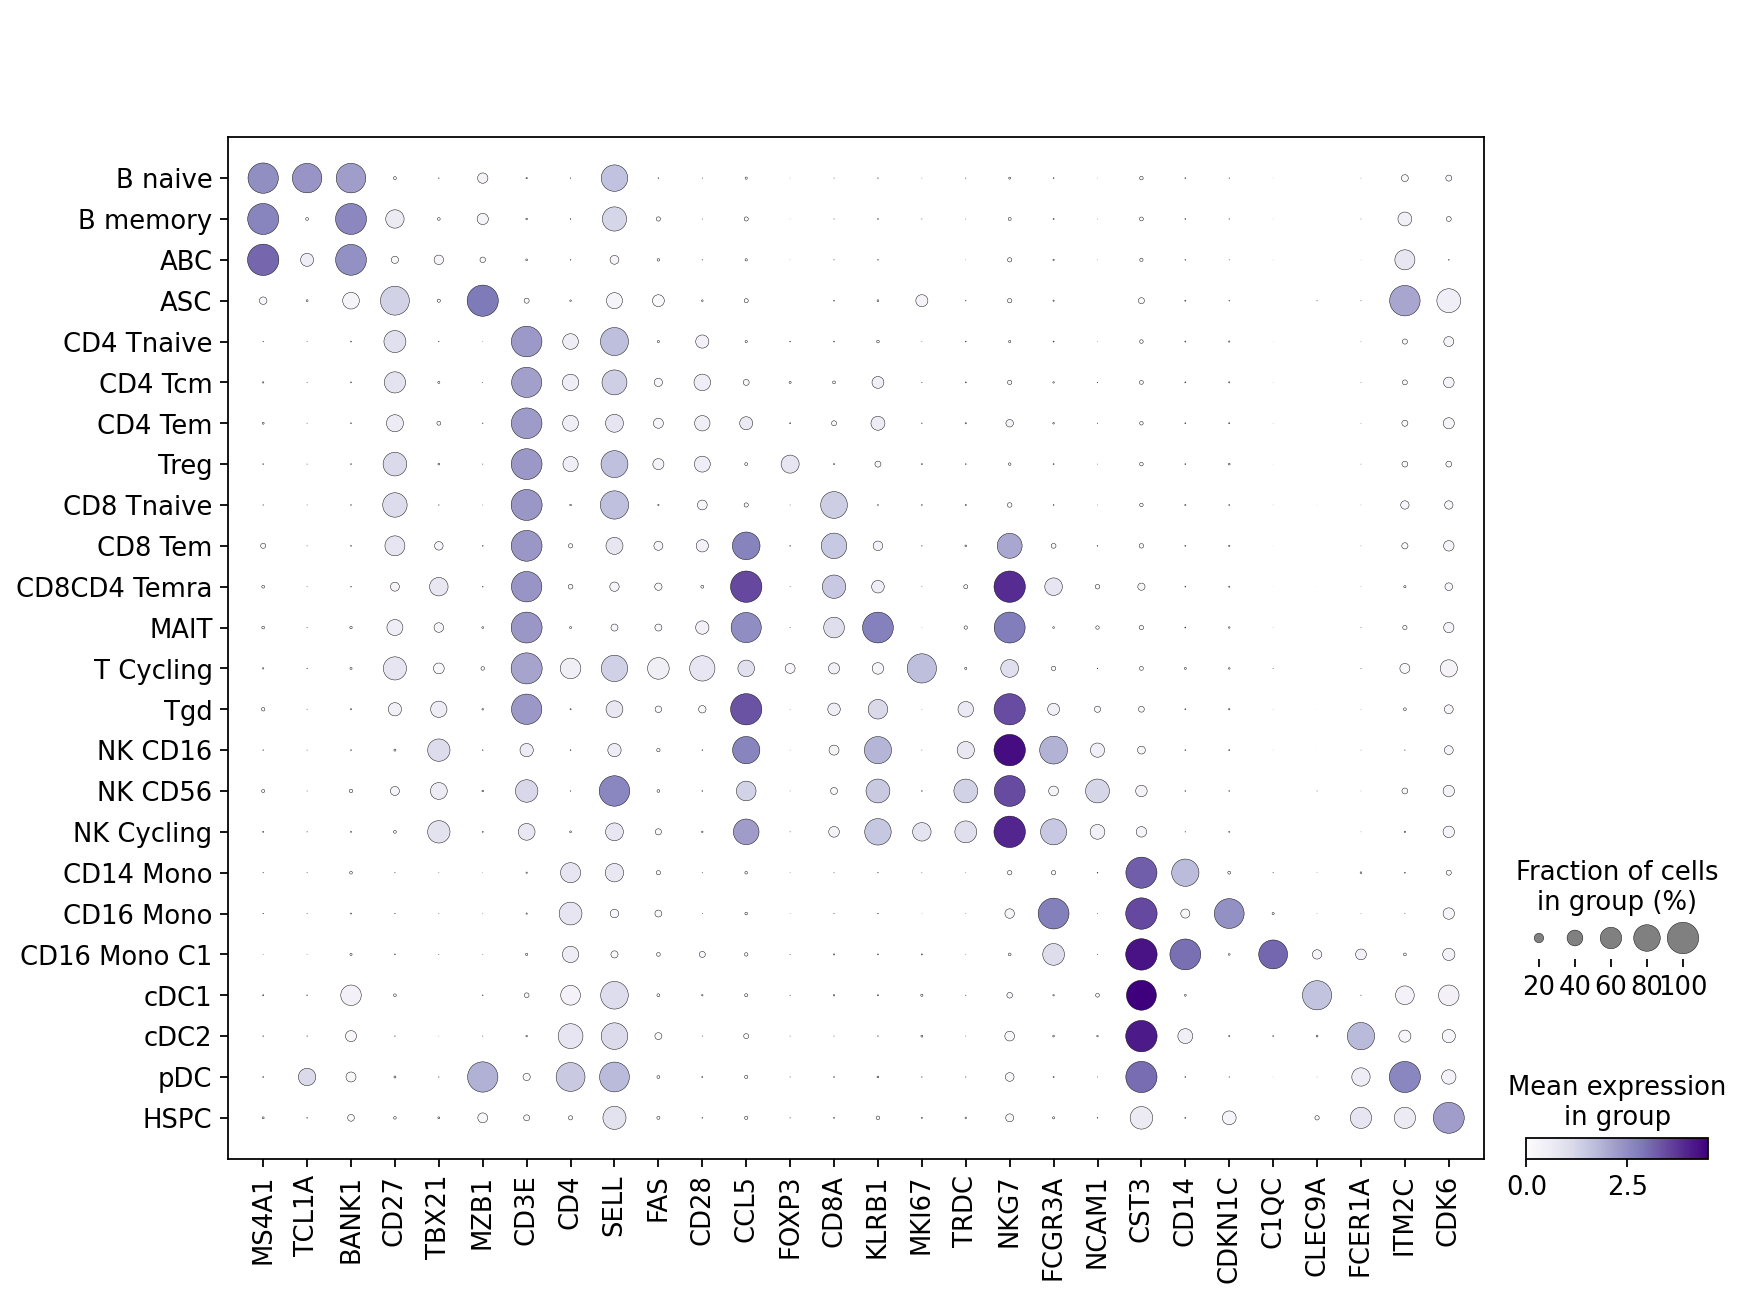

In [25]:
sc.pl.dotplot(adata, var_names=['MS4A1', 'TCL1A', 'BANK1', 'CD27', 'TBX21','MZB1', 
'CD3E', 'CD4', 'SELL', 'FAS', 'CD28', 'CCL5', 'FOXP3', 'CD8A', 'KLRB1', 'MKI67', 'TRDC',
'NKG7', 'FCGR3A', 'NCAM1', 'CST3', 'CD14', 'CDKN1C',
'C1QC',  'CLEC9A', 'FCER1A', 'ITM2C', 'CDK6'], 
    groupby='cluster_L2', cmap='Purples', save='l2markers')

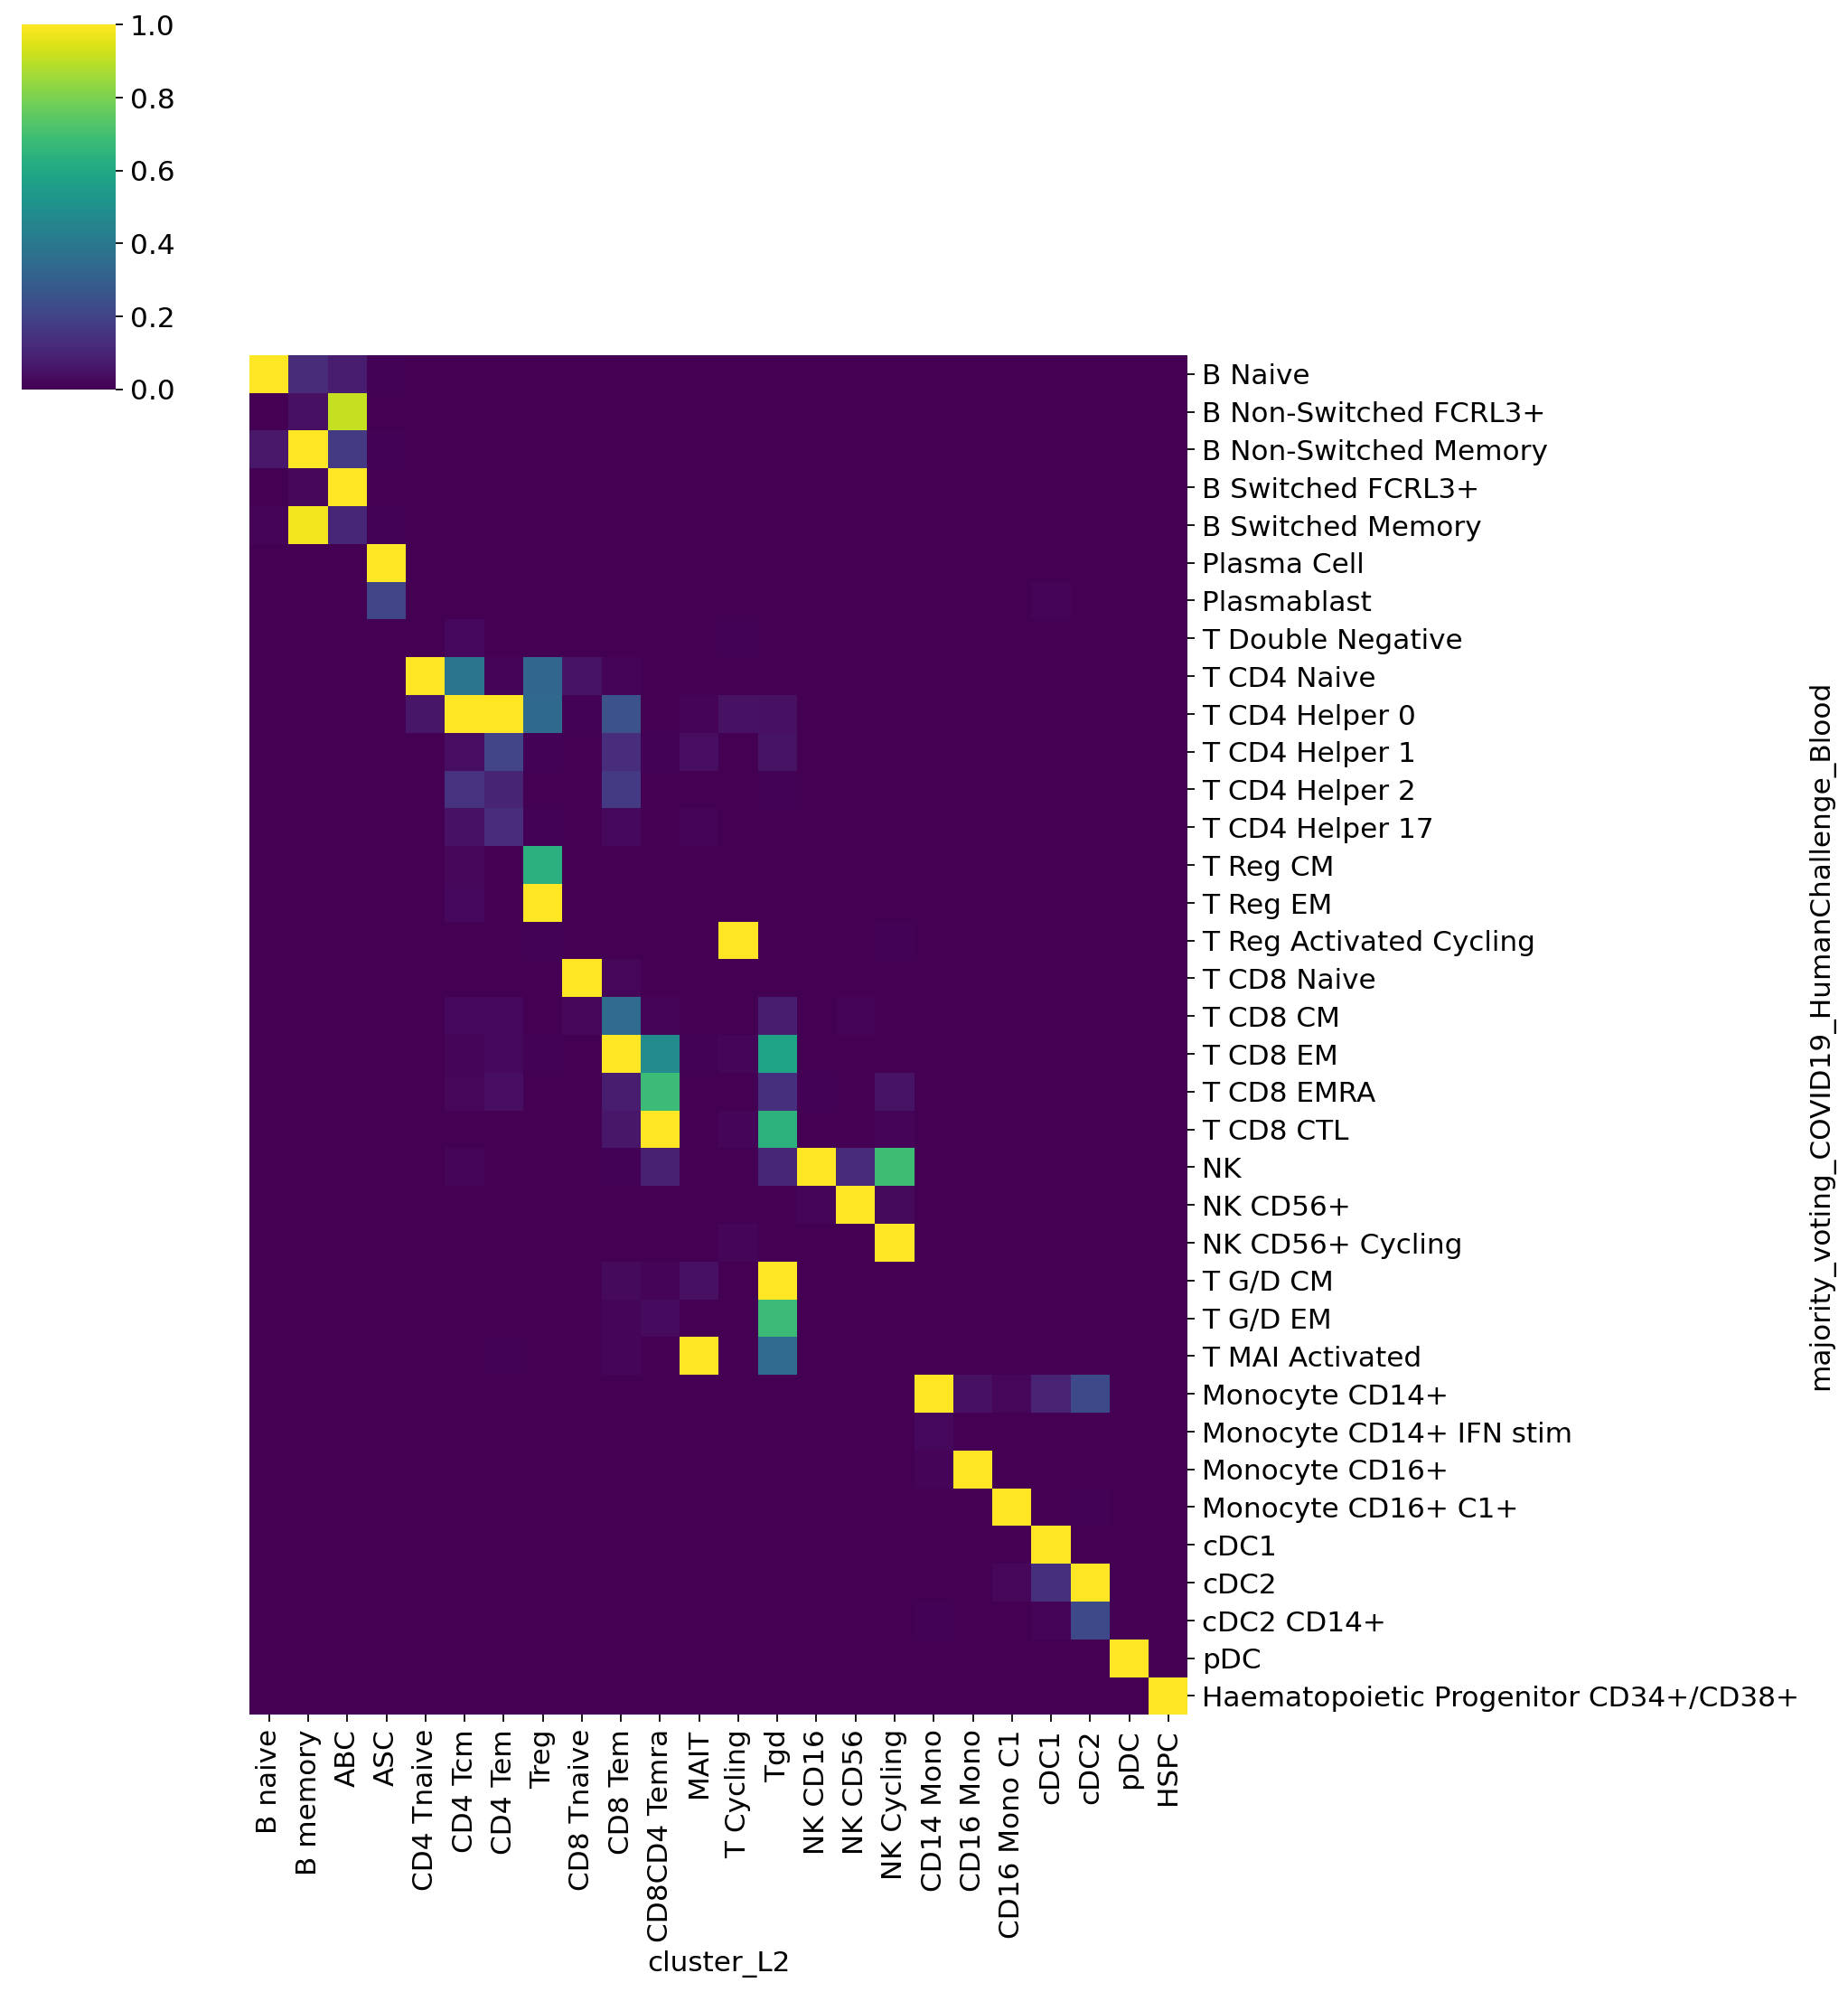

In [27]:
plt.rcParams['axes.grid'] = False

list_order = [
     'B Naive', 
       'B Non-Switched FCRL3+',
 'B Non-Switched Memory',
  'B Switched FCRL3+',
 'B Switched Memory',
 'Plasma Cell',
 'Plasmablast',
 'T Double Negative',
  'T CD4 Naive',
    'T CD4 Helper 0',
     'T CD4 Helper 1',
 'T CD4 Helper 2',
      'T CD4 Helper 17',
       'T Reg CM',
       'T Reg EM',
 'T Reg Activated Cycling',
        'T CD8 Naive',
 'T CD8 CM',
        'T CD8 EM',
         'T CD8 EMRA',
          'T CD8 CTL',
          'NK',
 'NK CD56+',
  'NK CD56+ Cycling',
         'T G/D CM',
          'T G/D EM',
          'T MAI Activated',
 'Monocyte CD14+',
  'Monocyte CD14+ IFN stim',
 'Monocyte CD16+',
 'Monocyte CD16+ C1+',
 'cDC1',
 'cDC2', 'cDC2 CD14+',
 'pDC',
  'Haematopoietic Progenitor CD34+/CD38+',

]

sns.clustermap(
    pd.crosstab(adata.obs['majority_voting_COVID19_HumanChallenge_Blood'], adata.obs['cluster_L2']).loc[list_order], 
    row_cluster=False,
    col_cluster=False,
    standard_scale=1,
    cmap='viridis',figsize=(13, 14)
    )
plt.savefig(f'../scanpy/{version}/graph/clustermap_majority_voting_COVID19_HumanChallenge_Blood.pdf', bbox_inches='tight')

In [9]:
list(adata.obs['majority_voting_COVID19_HumanChallenge_Blood'].unique())

['T CD8 EMRA',
 'Monocyte CD14+',
 'NK',
 'T CD8 EM',
 'T CD8 CTL',
 'B Switched Memory',
 'B Naive',
 'Monocyte CD16+',
 'T Reg CM',
 'T CD4 Helper 0',
 'T G/D CM',
 'T CD4 Naive',
 'Plasma Cell',
 'T CD4 Helper 2',
 'pDC',
 'Monocyte CD14+ IFN stim',
 'cDC2',
 'T Reg EM',
 'B Non-Switched FCRL3+',
 'T CD4 Helper 1',
 'T G/D EM',
 'T MAI Activated',
 'T CD8 CM',
 'B Non-Switched Memory',
 'NK CD56+',
 'T Reg Activated Cycling',
 'NK CD56+ Cycling',
 'B Switched FCRL3+',
 'T Double Negative',
 'T CD4 Helper 17',
 'cDC2 CD14+',
 'Haematopoietic Progenitor CD34+/CD38+',
 'cDC1',
 'T CD8 Naive',
 'Plasmablast',
 'Monocyte CD16+ C1+']

In [11]:
set(['T CD8 EMRA',
 'Monocyte CD14+',
 'NK',
 'T CD8 EM',
 'T CD8 CTL',
 'B Switched Memory',
 'B Naive',
 'Monocyte CD16+',
 'T Reg CM',
 'T CD4 Helper 0',
 'T G/D CM',
 'T CD4 Naive',
 'Plasma Cell',
 'T CD4 Helper 2',
 'pDC',
 'Monocyte CD14+ IFN stim',
 'cDC2',
 'T Reg EM',
 'B Non-Switched FCRL3+',
 'T CD4 Helper 1',
 'T G/D EM',
 'T MAI Activated',
 'T CD8 CM',
 'B Non-Switched Memory',
 'NK CD56+',
 'T Reg Activated Cycling',
 'NK CD56+ Cycling',
 'B Switched FCRL3+',
 'T Double Negative',
 'T CD4 Helper 17',
 'cDC2 CD14+',
 'Haematopoietic Progenitor CD34+/CD38+',
 'cDC1',
 'T CD8 Naive',
 'Plasmablast',
 'Monocyte CD16+ C1+']) - set([
     'B Naive', 
 'B Switched Memory',
 'Plasma Cell',

 'T Double Negative',
  'T CD4 Naive',
    'T CD4 Helper 0',
     'T CD4 Helper 1',
      'T CD4 Helper 17',
       'T Reg CM',
       'T Reg EM',
        'T CD8 Naive',
 'T CD8 CM',
        'T CD8 EM',
         'T CD8 EMRA',
          'NK',
 'NK CD56+',
         'T G/D CM',
          'T MAI Activated',
 'Monocyte CD14+',
 'Monocyte CD16+ C1+',
 'cDC1',
 'cDC2',
 'pDC',
  'Haematopoietic Progenitor CD34+/CD38+',
])

{'B Non-Switched FCRL3+',
 'B Non-Switched Memory',
 'B Switched FCRL3+',
 'Monocyte CD14+ IFN stim',
 'Monocyte CD16+',
 'NK CD56+ Cycling',
 'Plasmablast',
 'T CD4 Helper 2',
 'T CD8 CTL',
 'T G/D EM',
 'T Reg Activated Cycling',
 'cDC2 CD14+'}

In [ ]:
sc.pl.dotplot(adata[adata.obs['cluster_L2']=='CD4 Tcm'],
 var_names = ['KLRB1'],
 groupby='PD_Probability', cmap='seismic', standard_scale='var',
 categories_order=['HC', 'RBD-LowIntm', 'RBD-High', 'PD', 'PD-RBD'],
  save='KLRB1_CD4Tcm_PDprob',)

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/

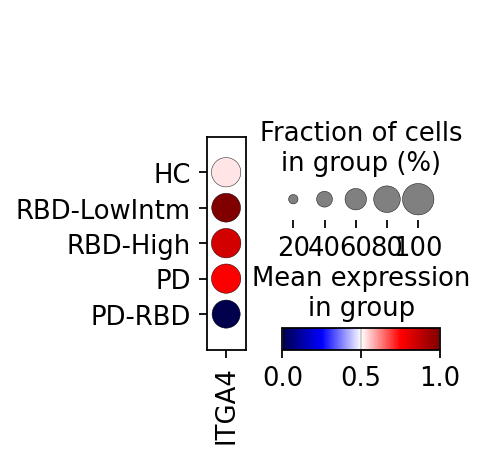

In [8]:
sc.pl.dotplot(adata[adata.obs['cluster_L2']=='CD16 Mono'], 
    var_names=['ITGA4'],
 groupby='PD_Probability', cmap='seismic', standard_scale='var',
 categories_order=['HC', 'RBD-LowIntm', 'RBD-High', 'PD', 'PD-RBD'],)

In [11]:
adata.obs['cluster_L1'].unique()

['T', 'Myeloid', 'B', 'NK', 'HSPC']
Categories (5, object): ['B', 'HSPC', 'Myeloid', 'NK', 'T']

/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/gpfs/gibbs/project/hafler/yy693/conda_envs/scanpy1.10.2/lib/python3.11/

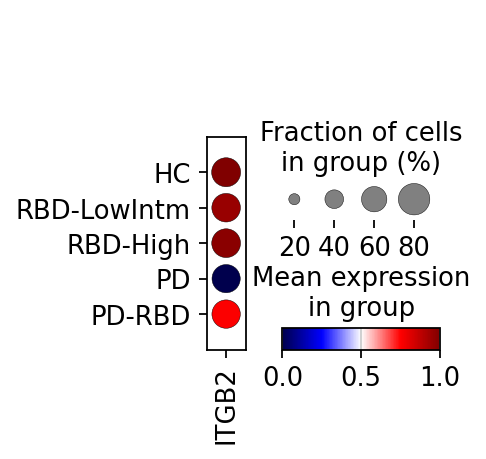

In [ ]:
sc.pl.dotplot(adata[adata.obs['cluster_L1']=='CD8CD4 Temra'],
 var_names = ['ITGB2'],
 groupby='PD_Probability', cmap='seismic', standard_scale='var',
 categories_order=['HC', 'RBD-LowIntm', 'RBD-High', 'PD', 'PD-RBD'],
  save='ITGB2_PDprob',)